# Sentiment Analysis on the Literary Works of Oscar Wilde
Oscar Wilde is one of my favourite authors ever. 'The Picture of Dorian Gray ' published in 1890, remains as one of the stories that has resonated and impacted me the most. The idea of a painting granting you a carte blanche and being the receptacle of ones evil while you live a life devoid of consequences was fascinating to me. In particular, the gradual deterioration of the painting as Dorian Gray committed increasingly terrible acts will always be one of my favorite concepts in literature. 

<figure class="half" style="display:flex">
    <img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Oscar_Wilde_3g07095u-adjust.jpg" width = 200 height = 400>
    <img src="http://hilsingermendelson.com/wp-content/uploads/2018/08/cover.jpg" width = 200 height = 400>
    <img src="https://sites.google.com/site/thepictureofdoriangray2/_/rsrc/1357874556041/historic-context/dorian.jpg" width = 475 height = 400>
</figure>

As such, it's only natural for me to want to investigate them through the lenses of data science and natural language processing (NLP) techniques. 

NLP is an amalgam of the concepts and techniques from the fields of linguistics, computer science, and artificial intelligence that seeks to understand how computers process human language. Some common tasks used by NLP are text and speech processing used in Speech recognition applications (i.e., Siri from Apple and Alexa from Amazon) and Higher-level applications like Discourse management (i.e., how can a computer converse with a human) amongst many others. It is an absolutely fascinating field and one that I've been deeply interested in from the moment I learned about it.

Some questions I'd want to answer are: 

* What are the most commonly used words used by Oscar Wilde?
* What is the overall sentiment present in his works?
* How does the sentiment change (if at all) from chapter to chapter? Is there a particular emotional structure that is present?
* Are the emotional assessments in agreement with the themes present in the narratives?

I'll write some code to download his works from <a href = "https://www.gutenberg.org/">Project Gutenberg</a>. These routines should be readily applicable to get stuff from other authors too!

The current workflow/structure of my process is as follows:

1. Programatically download books from Project Gutenberg. 
2. Programatically split the books into Chapters/Sections that can be subsequently processed. 
3. Tokenize, lemmatize, and denoise the book contents to prepare them for NLP analysis. 
4. Implement a Naive Bayes Classifier, the VADER and NRC lexicons to get progressively more detailed emotional breakdowns of the sentiments present in each chapter (joy, positive, anger, disgust, negative, anticipation, surprise, trust, fear, and surprise). 
5. Analyze the resulting polarity/emotion scores for each chapter/section on the book and see how they interplay with one another over the course of the story. 

My ultimate goal is to start generating a bit of an 'emotional database' for a variety of writers that could help me understand the way different authors express the quantified sentiments in their work. Then, with this, maybe one could start developing an algorithm/AI that could take the emotional/thematic elements from each writer and try to replicate their writing style. It would be pretty neat for instance to eventually generate a database of the sentiments of a variety of gothic horror writers like Mary Shelley, Bram Stoker, and Edgar Allan Poe and see how their stories are constructed. What are the common themes? What are the common sentiments? And can we parse/recognize these things through code?

With that said let's get started!

## Modules used in this work
The following modules were used to get this project done

In [1]:
#Modules for downloading stuff off Project Gutenberg
import os, requests
from os.path import basename
from os.path import join
from os import makedirs
from urllib.request import urlopen
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
from bs4 import BeautifulSoup
import re

#Stuff for general sentiment analysis
import nltk
from nltk.corpus import twitter_samples,stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

#More stuff for sentiment analysis
nltk.download('punkt') #Pretrained model to tokenize words
nltk.download('wordnet') #Lexical database to help determine base word
nltk.download('averaged_perceptron_tagger') #Used to determine context of word in sentence
nltk.download('omw-1.4')
nltk.download('stopwords')

#Stuff for VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#For NRC lexicon
from nrclex import NRCLex

#Stuff for dealing with strings and regular expressions
import re, string, random

#General modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

#Machine Learning Library for Python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Performance metrics for generated model
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.metrics import roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

#For WordCloud visualizations
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-d

## Prelude -- Communicating With Project Gutenberg 
The first thing I'll need is a way to retrieve the contents from the HTML site of Project Gutenberg. This means I'll need to communicate with the site/server which I can readily do with the <code>urlopen</code> function. The URL that I'm trying to connect to is associated with a search query for 'Oscar Wilde' and it looks as follows:

<code>https://www.gutenberg.org/ebooks/search/?query=oscar+wilde&submit_search=Search</code>

I'll be replacing the string to make it more general by using a formatted string of the form

<code>f'https://www.gutenberg.org/ebooks/search/?query={first_name}+{last_name}&submit_search=Search'</code>

I should note that Project Gutenberg queries are limited to 25 search results but that should be enough for this initial exploration.   

In [12]:
# download a file from a URL, returns content of downloaded file
def download_url(urlpath):
    try:
        # open a connection to the server
        with urlopen(urlpath, timeout=3) as connection:
            # read the contents of the url as bytes and return it
            return connection.read()
    except:
        return None

Cool, the function for generating the author first name and last name is shown below:

In [14]:
def getFirstLastName(author_name):
    aname = author_name.lower().rsplit()
    first_name = aname[0]
    last_name = aname[1]
    
    return first_name, last_name

author_name = 'Oscar Wilde'
firstname, lastname = getFirstLastName(author_name)
print(firstname, lastname)

oscar wilde


Great! Now we can search for any author. Next, I need a way to retrieve the URLs associated with book files from the search query. BeautifulSoup allows us to do this easily since all book links are contained within the <code>\<a href></code> tag. Hence, all that needs to be done is tell BeautifulSoup to find all the tags that begin with 'a' and then get the parts that contain an actual link that's denoted by 'href'. The function below takes care of that. 

In [15]:
# decode downloaded html and extract all <a href=""> links
def get_urls_from_html(content):
    
    # decode the provided content as ascii text
    html = content.decode('utf-8')
    
    # parse the document as best we can
    soup = BeautifulSoup(html, 'html.parser')
    
    # find all all of the <a href=""> tags in the document
    atags = soup.find_all('a')
    
    #Get links from search query page
    #nlinks = len(atags) - 25 - 5 
    #del(atags[0:5]) #Remove first six links since they don't correspond to books 
    #del(atags[-nlinks:])#Remove links that aren't book results (this query displays 25 books)
    
    # get all links from a tags
    return [tag.get('href') for tag in atags]

Now that we have the links present in the search query, I need to get the book identifiers that Project Gutenberg uses. This is done via the function below which will return a list of bookIDs that we can then use to download all the books associated with the results of our search query.

In [16]:
# return all book unique identifiers from a list of raw links
def get_book_identifiers(links):
    # define a url pattern we are looking for
    pattern = re.compile('/ebooks/[0-9]+')
    # process the list of links for those that match the pattern
    books = set()
    for link in links:
        # check of the link matches the pattern
        if not pattern.match(link):
            continue
        # extract the book id from /ebooks/nnn
        book_id = link[8:]
        # store in the set, only keep unique ids
        books.add(book_id)
    return books

We are almost done with the extraction prep for our books! Now that I have the bookIDs associated with the query results I can write a function that will download the book onto a directory in our computer. This is done with the function below. 

In [17]:
# download one book from project gutenberg
def download_book(book_id, save_path):
    print(save_path)
    # construct the download url
    url = f'https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt'
    # download the content
    data = download_url(url)
    if data is None:
        #print(f'Failed to download {url}')
        url = f'https://www.gutenberg.org/files/{book_id}/{book_id}.txt'
        data = download_url(url)
        if data is None:
            return f'Failed to download {url}'
        else:
            # create local path
            save_file = join(save_path, f'{book_id}.txt')
            # save book to file
            with open(save_file, 'wb') as file:
                file.write(data)
            return f'Saved {save_file}'
        
    # create local path
    save_file = join(save_path, f'{book_id}.txt')
    # save book to file
    with open(save_file, 'wb') as file:
        file.write(data)
    return f'Saved {save_file}'

Great! Let's try to download something now. I'll start by downloading Oscar Wilde's 'The Portrait of Dorian Gray' which has a book id of 174. I'll save the book in a directory called 'books'. 

In [ ]:
#Get current working directory and download book into 'books' directory
cwd = os.getcwd()
book_dir = cwd + '\\' + 'books'
test = download_book('174', book_dir)

The result of this function is shown below where you can see there's a text file called <code>174.txt</code> in my books directory.

<img src = "download pg result.jpg">


This file contains 'The Portrait of Dorian Gray' as you can see below.


<img src = "tpodg.jpg">

Perfect! Now that I have my base download function I can simply put my routines into a wrapper function that will allow me to download all the books present in our search query page as shown below.

In [18]:
def download_all_books(url, save_path):
    # download the page that lists top books
    data = download_url(url)
    print(f'.downloaded {url}')
    # extract all links from the page
    links = get_urls_from_html(data)
    print(f'.found {len(links)} links on the page')
    # retrieve all unique book ids
    book_ids = get_book_identifiers(links)
    print(f'.found {len(book_ids)} unique book ids')
    # create the save directory if needed
    makedirs(save_path, exist_ok=True)
    # download and save each book in turn
    for book_id in book_ids:
        print(book_id)
        # download and save this book
        result = download_book(book_id, save_path)
        # report result
        print(result)

Let's run the function and see what we get!

In [19]:
author_name = 'oscar wilde'
first_name, last_name = getFirstLastName(author_name)
author_url = f'https://www.gutenberg.org/ebooks/search/?query={first_name}+{last_name}&submit_search=Search'

#Get current working directory and download book into 'books' directory
cwd = os.getcwd()
book_dir = cwd + '\\' + 'books'

download_all_books(author_url, book_dir)

.downloaded https://www.gutenberg.org/ebooks/search/?query=oscar+wilde&submit_search=Search
.found 64 links on the page
.found 25 unique book ids
4078
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books\4078.txt
30120
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books\30120.txt
790
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books\790.txt
14522
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books\14522.txt
42704
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books\42704.txt
26950
C:\Users\vmurc\Documents\Python Scripts\Jupyter Notebooks\books
Saved C:\Users\vmurc\Documents\Python Sc

The results of the <code>download_all_books</code> function is shown below

<img src = "all books download.jpg">


Our function returned 23 out of the 25 results that were on the search query page. The 2 results that were omitted corresponded to an audio book for the 'The Importance of Being Earnest' and the German version of 'The Portrait of Dorian Gray' which is titled 'Das Bildnis des Dorian Gray'. This is totally okay though since for my work I'm only interested in text data and documents that are in English so I'll proceed with the next stage of the process.

## Preparing the book(s) for tokenization
Now that I have the books downloaded, I'm going to write a routine to split them into Chapters.

I'll start by writing a routine to read the books we downloaded and split them into chapters. 

In [303]:
book_id = '\\174.txt'          #What book are we processing?
book_name = book_dir + book_id #Location of book

#Open the book
book = open(book_name, "r", encoding="utf8") 
#Assign the book a name as string
book = str(book.read()) 
#Use regex to split the book into chapters by finding instances of the word CHAPTER
chapters = re.split("CHAPTER ", book)
#Remove first 21 CHAPTER instances since they are just fluff
del(chapters[0:20])
#Loops for the number of chapters in the book, starting at chapter 1
for i in range(1, len(chapters)+1):
    writeBook = open("{}.txt".format(i), "w+", encoding="utf8") #Make a new book
    writeBook.write(chapters[i-1]) #Write on book with current chapter content
    writeBook.close() #Closes the book

Next I'll load the book chapter files that we have generated to have them accessible

In [304]:
chapter_list = []
for file in os.listdir("."):
    if file.endswith(".txt"):
        chapter_list.append(file)

#Do a natural sort on the texts files 
chapter_list.sort(key=lambda x: '{0:0>8}'.format(x).lower())
chapter_list

['1.txt',
 '2.txt',
 '3.txt',
 '4.txt',
 '5.txt',
 '6.txt',
 '7.txt',
 '8.txt',
 '9.txt',
 '10.txt',
 '11.txt',
 '12.txt',
 '13.txt',
 '14.txt',
 '15.txt',
 '16.txt',
 '17.txt',
 '18.txt',
 '19.txt',
 '20.txt',
 '21.txt']

I'll eventually want to place the contents from each chapter and each book into a dataframe so this is just me trying to get things in there.

In [545]:
num_chapters = len(chapter_list)
chapter_names = []
df_list = []
i = 0
for file in chapter_list:
    chapter_name = 'Chapter ' + str(i)
    chapter_names.append(chapter_name)
    df = pd.read_csv(file,
                     sep = 'delimiter', 
                     header = 0,
                     names = [chapter_name],
                     encoding='utf-8',
                     on_bad_lines='skip',
                     squeeze = True,
                     engine='python'
                    )
    df_list.append(df)
    i += 1
    
df_tot = pd.concat(df_list, axis =1, names = chapter_names)
df_tot.head(3)

Chapter 0  \
0                                        THE PREFACE   
1  The artist is the creator of beautiful things....   
2  conceal the artist is art’s aim. The critic is...   

                                           Chapter 1  \
0  The studio was filled with the rich odour of r...   
1  summer wind stirred amidst the trees of the ga...   
2  the open door the heavy scent of the lilac, or...   

                                           Chapter 2  \
0  As they entered they saw Dorian Gray. He was s...   
1  his back to them, turning over the pages of a ...   
2  “Forest Scenes.” “You must lend me these, Basi...   

                                           Chapter 3  \
0  At half-past twelve next day Lord Henry Wotton...   
1  Street over to the Albany to call on his uncle...   
2  if somewhat rough-mannered old bachelor, whom ...   

                                           Chapter 4  \
0  One afternoon, a month later, Dorian Gray was ...   
1  arm-chair, in the little library of Lord Henry...   
2  was, in its way, a very charming room, with it...   

                                           Chapter 5  \
0  “Mother, Mother, I am so happy!” whispered the...   
1  in the lap of the faded, tired-looking woman w...   
2  the shrill intrusive light, was sitting in the...   

                                           Chapter 6  \
0  “I suppose you have heard the news, Basil?” sa...   
1  evening as Hallward was shown into a little pr...   
2              where dinner had been laid for three.   

                                           Chapter 7  \
0  For some reason or other, the house was crowde...   
1  Jew manager who met them at the door was beami...   
2  an oily tremulous smile. He escorted them to t...   

                                           Chapter 8  \
0  It was long past noon when he awoke. His valet...   
1  on tiptoe into the room to see if he was stirr...   
2  what made his young master sleep so late. Fina...   

                                           Chapter 9  ...  \
0  As he was sitting at breakfast next morning, B...  ...   
1                                     into the room.  ...   
2  “I am so glad I have found you, Dorian,” he sa...  ...   

                                          Chapter 11  \
0  For years, Dorian Gray could not free himself ...   
1  this book. Or perhaps it would be more accurat...   
2  sought to free himself from it. He procured fr...   

                                          Chapter 12  \
0  It was on the ninth of November, the eve of hi...   
1       birthday, as he often remembered afterwards.   
2  He was walking home about eleven o’clock from ...   

                                          Chapter 13  \
0  He passed out of the room and began the ascent...   
1  following close behind. They walked softly, as...   
2  night. The lamp cast fantastic shadows on the ...   

                                          Chapter 14  \
0  At nine o’clock the next morning his servant c...   
1  chocolate on a tray and opened the shutters. D...   
2  peacefully, lying on his right side, with one ...   

                                          Chapter 15  \
0  That evening, at eight-thirty, exquisitely dre...   
1  button-hole of Parma violets, Dorian Gray was ...   
2  Narborough’s drawing-room by bowing servants. ...   

                                          Chapter 16  \
0  A cold rain began to fall, and the blurred str...   
1  in the dripping mist. The public-houses were j...   
2  and women were clustering in broken groups rou...   

                                          Chapter 17  \
0  A week later Dorian Gray was sitting in the co...   
1  Royal, talking to the pretty Duchess of Monmou...   
2  a jaded-looking man of sixty, was amongst his ...   

                                          Chapter 18  \
0  The next day he did not leave the house, and, ...   
1  time in his own room, sick with a wild terror ...   
2  indifferent to life itself.

Finally, I'll  read the contents of the book and place them in memory here. I'll start with Chapter 1 which was saved as a file named '2.txt' since the current book has a Prelude Chapter

In [305]:
with open('2.txt', encoding = 'utf-8') as f:
    contents = f.read().rstrip()
print(contents[0:248])

I.


The studio was filled with the rich odour of roses, and when the light
summer wind stirred amidst the trees of the garden, there came through
the open door the heavy scent of the lilac, or the more delicate
perfume of the pink-flowering thorn.


We are ready to roll! 
## Tokenizing the Chapter
Let's start by tokenizing the chapter. I'll use the <code>word_tokenize</code> function from nltk. I'll also remove the first three elements from the tokenized list since those are just the chapter numbers and empty lines.

In [306]:
chap_token = word_tokenize(contents)
del(chap_token[0:2])
chap_token[0:20]

['The',
 'studio',
 'was',
 'filled',
 'with',
 'the',
 'rich',
 'odour',
 'of',
 'roses',
 ',',
 'and',
 'when',
 'the',
 'light',
 'summer',
 'wind',
 'stirred',
 'amidst',
 'the']

## Tagging the words in the chapter
Now I'm going to tag each of the words in the book

In [307]:
pos_tag(chap_token)[0:20]

[('The', 'DT'),
 ('studio', 'NN'),
 ('was', 'VBD'),
 ('filled', 'VBN'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('rich', 'JJ'),
 ('odour', 'NN'),
 ('of', 'IN'),
 ('roses', 'NNS'),
 (',', ','),
 ('and', 'CC'),
 ('when', 'WRB'),
 ('the', 'DT'),
 ('light', 'JJ'),
 ('summer', 'NN'),
 ('wind', 'NN'),
 ('stirred', 'VBD'),
 ('amidst', 'IN'),
 ('the', 'DT')]

That worked! Every tokenized word has a tag associated with it now.
## Lemmatizing the words in the chapter
Now I'm going to lemmatize the chapter

In [308]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

lemm_chapter = lemmatize_sentence(chap_token)
lemm_chapter[0:20]

['The',
 'studio',
 'be',
 'fill',
 'with',
 'the',
 'rich',
 'odour',
 'of',
 'rose',
 ',',
 'and',
 'when',
 'the',
 'light',
 'summer',
 'wind',
 'stir',
 'amidst',
 'the']

Perfect! Words have been lemmatized. Notice how there is a comma token under rose. I'll remove that and other things as part of the denoising/cleanup process.
## Denoising the text
Now I'm going to denoise the chapter by removing punctuations and special quote characters

In [309]:
stop_words = stopwords.words('english')

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        if len(token) > 0 and (token == "“") or (token == "”") or (token == "’"):
            continue
        elif len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
        
    return cleaned_tokens

In [310]:
denoised_chapter = remove_noise(lemm_chapter, stop_words)
denoised_chapter[0:20]

['studio',
 'fill',
 'rich',
 'odour',
 'rise',
 'light',
 'summer',
 'wind',
 'stir',
 'amidst',
 'tree',
 'garden',
 'come',
 'open',
 'door',
 'heavy',
 'scent',
 'lilac',
 'delicate',
 'perfume']

## Calculating Word Density for Chapter
Nice! Now let's get the word density for Chapter 1!

These are the 20 most common words in Chapter 1:
[('say', 29), ('one', 27), ('know', 26), ('lord', 22), ('tell', 22), ('dorian', 22), ('basil', 21), ('henry', 20), ('like', 20), ('gray', 20), ('thing', 19), ('harry', 19), ('never', 18), ('seem', 16), ('think', 16), ('hallward', 16), ('look', 16), ('art', 14), ('good', 14), ('make', 13)]


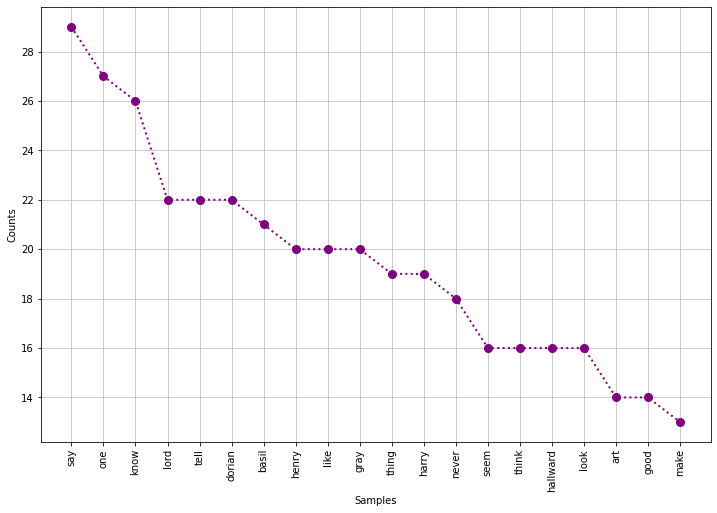

In [311]:
freq_dist_pos = FreqDist(denoised_chapter)
print('These are the 20 most common words in Chapter 1:')
print(freq_dist_pos.most_common(20))
fig = plt.figure(figsize=(12,8))
freq_dist_pos.plot(20, cumulative=False,color = 'purple', linestyle = ':', marker='.', markersize=16)
plt.show()

Looks like the most common word in this chapter is 'say' with 29 instances, followed by the word 'one' with 27 instances. 

## Training the Classifier
Now let's train a model! I'll start by using a Naive Bayes Classifier based on the twitter_samples dataset and see how that works out. I've covered this in a previous post so I'll just include the code here. This will allow me to readily classify words as being associated with positive or negative  sentiments. I will later try to classify the words, sentences, chapters and entire book with more detailed emotions like joy, sadness, anger, and such.  

In [7]:
#Get twitter_samples
nltk.download('twitter_samples') #30000 tweets. 5000 positive, 5000 negative. Rest are neutral.
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

#Clean up of all tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

#Get tweets ready for modeling
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)
        
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive") 
                    for tweet_dict in positive_tokens_for_model]
negative_dataset = [(tweet_dict, "Negative") 
                    for tweet_dict in negative_tokens_for_model]

#Combine positive and negative tweets
dataset = positive_dataset + negative_dataset

#Shuffle generated dataset
random.shuffle(dataset)

#Do an 80:20 split on the dataset. 80 on the testing set and 20 on the training set
train_data = dataset[:2000]
test_data  = dataset[8000:]

classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\vmurc\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Accuracy is: 0.992
Most Informative Features
                    miss = True           Negati : Positi =     10.8 : 1.0
                     sad = True           Negati : Positi =      9.0 : 1.0
                      :( = None           Positi : Negati =      8.6 : 1.0
                  lovely = True           Positi : Negati =      8.0 : 1.0
                    hurt = True           Negati : Positi =      7.9 : 1.0
                   sorry = True           Negati : Positi =      7.9 : 1.0
                  asleep = True           Negati : Positi =      7.3 : 1.0
                    sick = True           Negati : Positi =      7.3 : 1.0
                   happy = True           Positi : Negati =      7.0 : 1.0
                followed = True           Negati : Positi =      6.7 : 1.0
None


The classifier has a 99.55% accuracy. Now that I have a trained classifier, let's apply it to our chapter!

## Applying the Clasifier to the chapter

In [313]:
def get_chapters_for_model(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        yield dict([tokens, True] for token in tokens)

In [290]:
denoised_chapter[0]

'studio'

In [640]:
print('This is the dictionary for the tokenized and denoised words in Chapter 1 from:')
print("The Portrait of Dorian Gray")
tokens_for_model = get_chapters_for_model(denoised_chapter)
list(tokens_for_model)[:15]

This is the dictionary for the tokenized and denoised words in Chapter 1 from:
The Portrait of Dorian Gray


[{'studio': True},
 {'fill': True},
 {'rich': True},
 {'odour': True},
 {'rise': True},
 {'light': True},
 {'summer': True},
 {'wind': True},
 {'stir': True},
 {'amidst': True},
 {'tree': True},
 {'garden': True},
 {'come': True},
 {'open': True},
 {'door': True}]

In [322]:
print(classifier.classify(dict([token, True] for token in tokens_for_model)))

Negative


It looks like the overall sentiment for Chapter 1 is positive based on the simple classifier built using Naive Bayes. 
## Wrapper function for Performing Sentiment Analysis on Book
Let me compile my routines and subsequently process all the chapters in the book and see what's the overall sentiment in each chapter and the book using this model.

In [5]:
def split_book_into_chapters(book_dir, book_id):
    
    book_name = book_dir + book_id #Location of book
    
    #Open the book
    book = open(book_name, "r", encoding="utf8") 
    #Assign the book a name as string
    book = str(book.read()) 
    #Use regex to split the book into chapters by finding instances of the word CHAPTER
    chapters = re.split("CHAPTER ", book)
    #Remove first 21 CHAPTER instances since they are just fluff
    del(chapters[0:20])
    #Loops for the number of chapters in the book, starting at chapter 1
    for i in range(1, len(chapters)+1):
        book_chapter = open("{}.txt".format(i), "w+", encoding="utf8") #Make a new book
        book_chapter.write(chapters[i-1]) #Write on book with current chapter content
        book_chapter.close() #Closes the book
    
    chapter_list = []
    for file in os.listdir("."):
        if file.endswith(".txt"):
            chapter_list.append(file)

    #Do a natural sort on the texts files 
    chapter_list.sort(key=lambda x: '{0:0>8}'.format(x).lower())
    return chapter_list

def get_book_chapters(chapter_list, chapter_num):

    chapter_to_read = chapter_list[chapter_num]
    
    #Open text file containing book chapter and read contents
    with open(chapter_to_read, encoding = 'utf-8') as f:
        chapter_contents = f.read().rstrip()
    
    return chapter_contents

def tokenize_chapter_contents(contents):
    chap_token = word_tokenize(contents)
    del(chap_token[0:2])
    
    return chap_token

def lemmatize_chapter(chap_token):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(chap_token):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        if len(token) > 0 and (token == "“") or (token == "”") or (token == "’"):
            continue
        elif len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
        
    return cleaned_tokens

def get_chapters_for_model(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        yield dict([tokens, True] for token in tokens)
        
def book_sentiment_wrapper(book_dir, book_id,stop_words):
    
    #Start by splitting book into chapters and saving them into textfiles
    chapter_list = split_book_into_chapters(book_dir, book_id)
    num_chapters = len(chapter_list)
    
    #Initialize sentiment array
    book_sentiment = []
    chapter_num = 0
    for chapter_num in range(num_chapters):
        #print('Processing Chapter ', chapter_num)
        chapter_contents = get_book_chapters(chapter_list, chapter_num)
        chap_token       = tokenize_chapter_contents(chapter_contents)
        lemmatized_chap  = lemmatize_chapter(chap_token)
        #print(lemmatized_chap[:10])
        denoised_chapter = remove_noise(lemmatized_chap, stop_words)
        #print(denoised_chapter[:10])
        tokens_for_model = get_chapters_for_model(denoised_chapter)
        list(tokens_for_model)
        #print(tokens_for_model)
        chap_sentiment   = classifier.classify(dict([token, True] for token in tokens_for_model))
        
        print('Chapter ', chapter_num, ' Sentiment is ', chap_sentiment)
        book_sentiment.append(chap_sentiment)
        
        chapter_num += 1
    
    print('Book Completed!')
    return book_sentiment

In [326]:
book_id = '\\174.txt'           #What book are we processing?
cwd = os.getcwd()               #Get current working directory
book_dir = cwd + '\\' + 'books' #Where is the book located?
stop_words = stopwords.words('english') #What are the stopwords to use?
book_sentiment = book_sentiment_wrapper(book_dir, book_id, stop_words)

Chapter  0  Sentiment is  Negative
Chapter  1  Sentiment is  Negative
Chapter  2  Sentiment is  Negative
Chapter  3  Sentiment is  Negative
Chapter  4  Sentiment is  Negative
Chapter  5  Sentiment is  Negative
Chapter  6  Sentiment is  Negative
Chapter  7  Sentiment is  Negative
Chapter  8  Sentiment is  Negative
Chapter  9  Sentiment is  Negative
Chapter  10  Sentiment is  Negative
Chapter  11  Sentiment is  Negative
Chapter  12  Sentiment is  Negative
Chapter  13  Sentiment is  Negative
Chapter  14  Sentiment is  Negative
Chapter  15  Sentiment is  Negative
Chapter  16  Sentiment is  Negative
Chapter  17  Sentiment is  Negative
Chapter  18  Sentiment is  Negative
Chapter  19  Sentiment is  Negative
Chapter  20  Sentiment is  Negative
Book Completed!


Woah! All of the chapters are classified to have negative sentiments associated with them. This does seem to be in agreement with the overall tone of the book. However... the results of this analysis are kinda boring. Let me manually check a few sentences from Chapter 1 as a sanity check to ensure that the classifier is capable of classifying sentences that I would consider positive/negative.

I'll start with a negative sentence

In [338]:
sentence = "I don’t want you to meet him."

custom_tokens = remove_noise(word_tokenize(sentence))
print(custom_tokens)
print(classifier.classify(dict([token, True] for token in custom_tokens)))

['i', 'don', 't', 'want', 'you', 'to', 'meet', 'him']
Negative


Okay, that seems fine. Contractions are not being dealt with properly though. I'll have to go back into my tokenizer function and fix that. And now I'll try a positive sentence:

In [339]:
sentence = "Lord Henry smiled, and leaning down, plucked a pink-petalled daisy from \
the grass and examined it."

custom_tokens = remove_noise(word_tokenize(sentence))
print(custom_tokens)
print(classifier.classify(dict([token, True] for token in custom_tokens)))

['lord', 'henry', 'smile', 'and', 'lean', 'down', 'pluck', 'a', 'pink-petalled', 'daisy', 'from', 'the', 'grass', 'and', 'examine', 'it']
Positive


Okay, it is capable of classifying sentences as positive. 

However, I want to see if a more 'colorful' chapter assessment can be made using Emotion Detection/Recognition through VADER and NRC lexicons.

## Sentiment Analysis using VADER
VADER will give polarity scores. Even though the sentiment categorization is still set to a simple positive, negative, or neutral, we will get a quantifiable metric for each of those values and start getting a better idea of the sentiment composition from each chapter. I'll first modify my wrapper routine from above so that it returns the chapter contents as part of the output.

In [12]:
def book_sentiment_wrapper(book_dir, book_id,stop_words):
    
    #Start by splitting book into chapters and saving them into textfiles
    chapter_list = split_book_into_chapters(book_dir, book_id)
    num_chapters = len(chapter_list)
    
    #Initialize sentiment array
    book_sentiment = []
    cleaned_chaps  = []
    chapter_num = 0
    for chapter_num in range(num_chapters):
        #print('Processing Chapter ', chapter_num)
        chapter_contents = get_book_chapters(chapter_list, chapter_num)
        chap_token       = tokenize_chapter_contents(chapter_contents)
        lemmatized_chap  = lemmatize_chapter(chap_token)
        #print(lemmatized_chap[:10])
        denoised_chapter = remove_noise(lemmatized_chap, stop_words)
        cleaned_chaps.append(denoised_chapter)
        #print(denoised_chapter[:10])
        tokens_for_model = get_chapters_for_model(denoised_chapter)
        list(tokens_for_model)
        #print(tokens_for_model)
        chap_sentiment   = classifier.classify(dict([token, True] for token in tokens_for_model))
        
        #print('Chapter ', chapter_num, ' Sentiment is ', chap_sentiment)
        book_sentiment.append(chap_sentiment)
        
        chapter_num += 1
    
    print('Book Completed!')
    return book_sentiment, cleaned_chaps

Now I'll rerun my function on the entire book to get the chapter contents. These chapter contents have already been tokenized, normalized and denoised.

In [13]:
book_id = '\\174.txt'           #What book are we processing?
cwd = os.getcwd()               #Get current working directory
book_dir = cwd + '\\' + 'books' #Where is the book located?
stop_words = stopwords.words('english') #What are the stopwords to use?
book_sentiment, cleaned_chaps = book_sentiment_wrapper(book_dir, book_id, stop_words)

Book Completed!


Next, I'll create a pandas dataframe that will hold the contents from each chapter on each row.

In [14]:
chap_list = []
for i in range(len(cleaned_chaps)):
    chap_elem = ' '.join(cleaned_chaps[i])
    chap_list.append(chap_elem)

#Make pandas dataframe. Each row is a chapter
df_pos = pd.DataFrame(chap_list, columns=['chapter_contents'])

#Add column with Chapter names. 
chapter_names = ['Prelude']
i = 0
for i in range(len(cleaned_chaps)- 1):
    chap_to_add = 'Chapter ' + str(i+1)
    chapter_names.append(chap_to_add)
    
#Make series for book id since I'll be processing multiple books later   
book_id_col = []
i = 0
for i in range(len(cleaned_chaps)):
    book_id_col.append(book_id.replace('\\', '').replace('.txt', ''))

df_pos.insert(0, column='Book_ID', value = book_id_col)    
df_pos.insert(1, column='Chapter_Name', value = chapter_names)
df_pos

Book_ID Chapter_Name                                   chapter_contents
0      174      Prelude  preface artist creator beautiful thing reveal ...
1      174    Chapter 1  studio fill rich odour rise light summer wind ...
2      174    Chapter 2  enter saw dorian gray seat piano back turn pag...
3      174    Chapter 3  half-past twelve next day lord henry wotton st...
4      174    Chapter 4  one afternoon month late dorian gray recline l...
5      174    Chapter 5  mother mother happy whisper girl bury face lap...
6      174    Chapter 6  suppose hear news basil say lord henry even ha...
7      174    Chapter 7  reason house crowd night fat jew manager meet ...
8      174    Chapter 8  long past noon awake valet creep several time ...
9      174    Chapter 9  sit breakfast next morning basil hallward show...
10     174   Chapter 10  servant enter look steadfastly wonder think pe...
11     174   Chapter 11  year dorian gray could free influence book per...
12     174   Chapter 12  ninth november eve thirty-eighth birthday ofte...
13     174   Chapter 13  pass room begin ascent basil hallward follow c...
14     174   Chapter 14  nine clock next morning servant come cup choco...
15     174   Chapter 15  evening eight-thirty exquisitely dress wear la...
16     174   Chapter 16  cold rain begin fall blurred street-lamps look...
17     174   Chapter 17  week late dorian gray sit conservatory selby r...
18     174   Chapter 18  next day leave house indeed spend time room si...
19     174   Chapter 19  use tell go good cry lord henry dip white fing...
20     174   Chapter 20  lovely night warm throw coat arm even put silk...

And now I'll run the SentimentIntensityAnalyzer using VADER and see what we get

In [15]:
sid = SentimentIntensityAnalyzer()
df_pos['compound'] = [sid.polarity_scores(x)['compound'] for x in df_pos['chapter_contents']]
df_pos['neg']      = [sid.polarity_scores(x)['neg'] for x in      df_pos['chapter_contents']]
df_pos['neu']      = [sid.polarity_scores(x)['neu'] for x in      df_pos['chapter_contents']]
df_pos['pos']      = [sid.polarity_scores(x)['pos'] for x in      df_pos['chapter_contents']]
df_pos

Book_ID Chapter_Name                                   chapter_contents  \
0      174      Prelude  preface artist creator beautiful thing reveal ...   
1      174    Chapter 1  studio fill rich odour rise light summer wind ...   
2      174    Chapter 2  enter saw dorian gray seat piano back turn pag...   
3      174    Chapter 3  half-past twelve next day lord henry wotton st...   
4      174    Chapter 4  one afternoon month late dorian gray recline l...   
5      174    Chapter 5  mother mother happy whisper girl bury face lap...   
6      174    Chapter 6  suppose hear news basil say lord henry even ha...   
7      174    Chapter 7  reason house crowd night fat jew manager meet ...   
8      174    Chapter 8  long past noon awake valet creep several time ...   
9      174    Chapter 9  sit breakfast next morning basil hallward show...   
10     174   Chapter 10  servant enter look steadfastly wonder think pe...   
11     174   Chapter 11  year dorian gray could free influence book per...   
12     174   Chapter 12  ninth november eve thirty-eighth birthday ofte...   
13     174   Chapter 13  pass room begin ascent basil hallward follow c...   
14     174   Chapter 14  nine clock next morning servant come cup choco...   
15     174   Chapter 15  evening eight-thirty exquisitely dress wear la...   
16     174   Chapter 16  cold rain begin fall blurred street-lamps look...   
17     174   Chapter 17  week late dorian gray sit conservatory selby r...   
18     174   Chapter 18  next day leave house indeed spend time room si...   
19     174   Chapter 19  use tell go good cry lord henry dip white fing...   
20     174   Chapter 20  lovely night warm throw coat arm even put silk...   

    compound    neg    neu    pos  
0     0.9837  0.186  0.514  0.300  
1     0.9999  0.118  0.616  0.266  
2     0.9999  0.121  0.633  0.246  
3     0.9998  0.139  0.610  0.251  
4     0.9999  0.111  0.613  0.276  
5     0.9998  0.152  0.585  0.264  
6     0.9999  0.129  0.567  0.304  
7     0.9996  0.179  0.578  0.242  
8     0.9971  0.185  0.601  0.214  
9     0.9994  0.168  0.591  0.241  
10    0.9979  0.131  0.687  0.182  
11    0.9998  0.141  0.655  0.205  
12    0.9966  0.157  0.637  0.206  
13   -0.9917  0.173  0.685  0.142  
14    0.9488  0.172  0.646  0.181  
15    0.9996  0.136  0.636  0.228  
16   -0.9993  0.226  0.619  0.155  
17    0.9992  0.150  0.584  0.267  
18   -0.9966  0.224  0.580  0.196  
19    0.9994  0.158  0.605  0.237  
20    0.9993  0.129  0.690  0.181

Okay, now things are starting to get a bit more interesting. Each chapter has different positive, negative and neutral scores associated with them. Furthermore, the compound scores (which represent the overall sentiment with +1 being the most positive and -1 being the most negative) are also different between chapters. Let me plot them and see how it looks like!

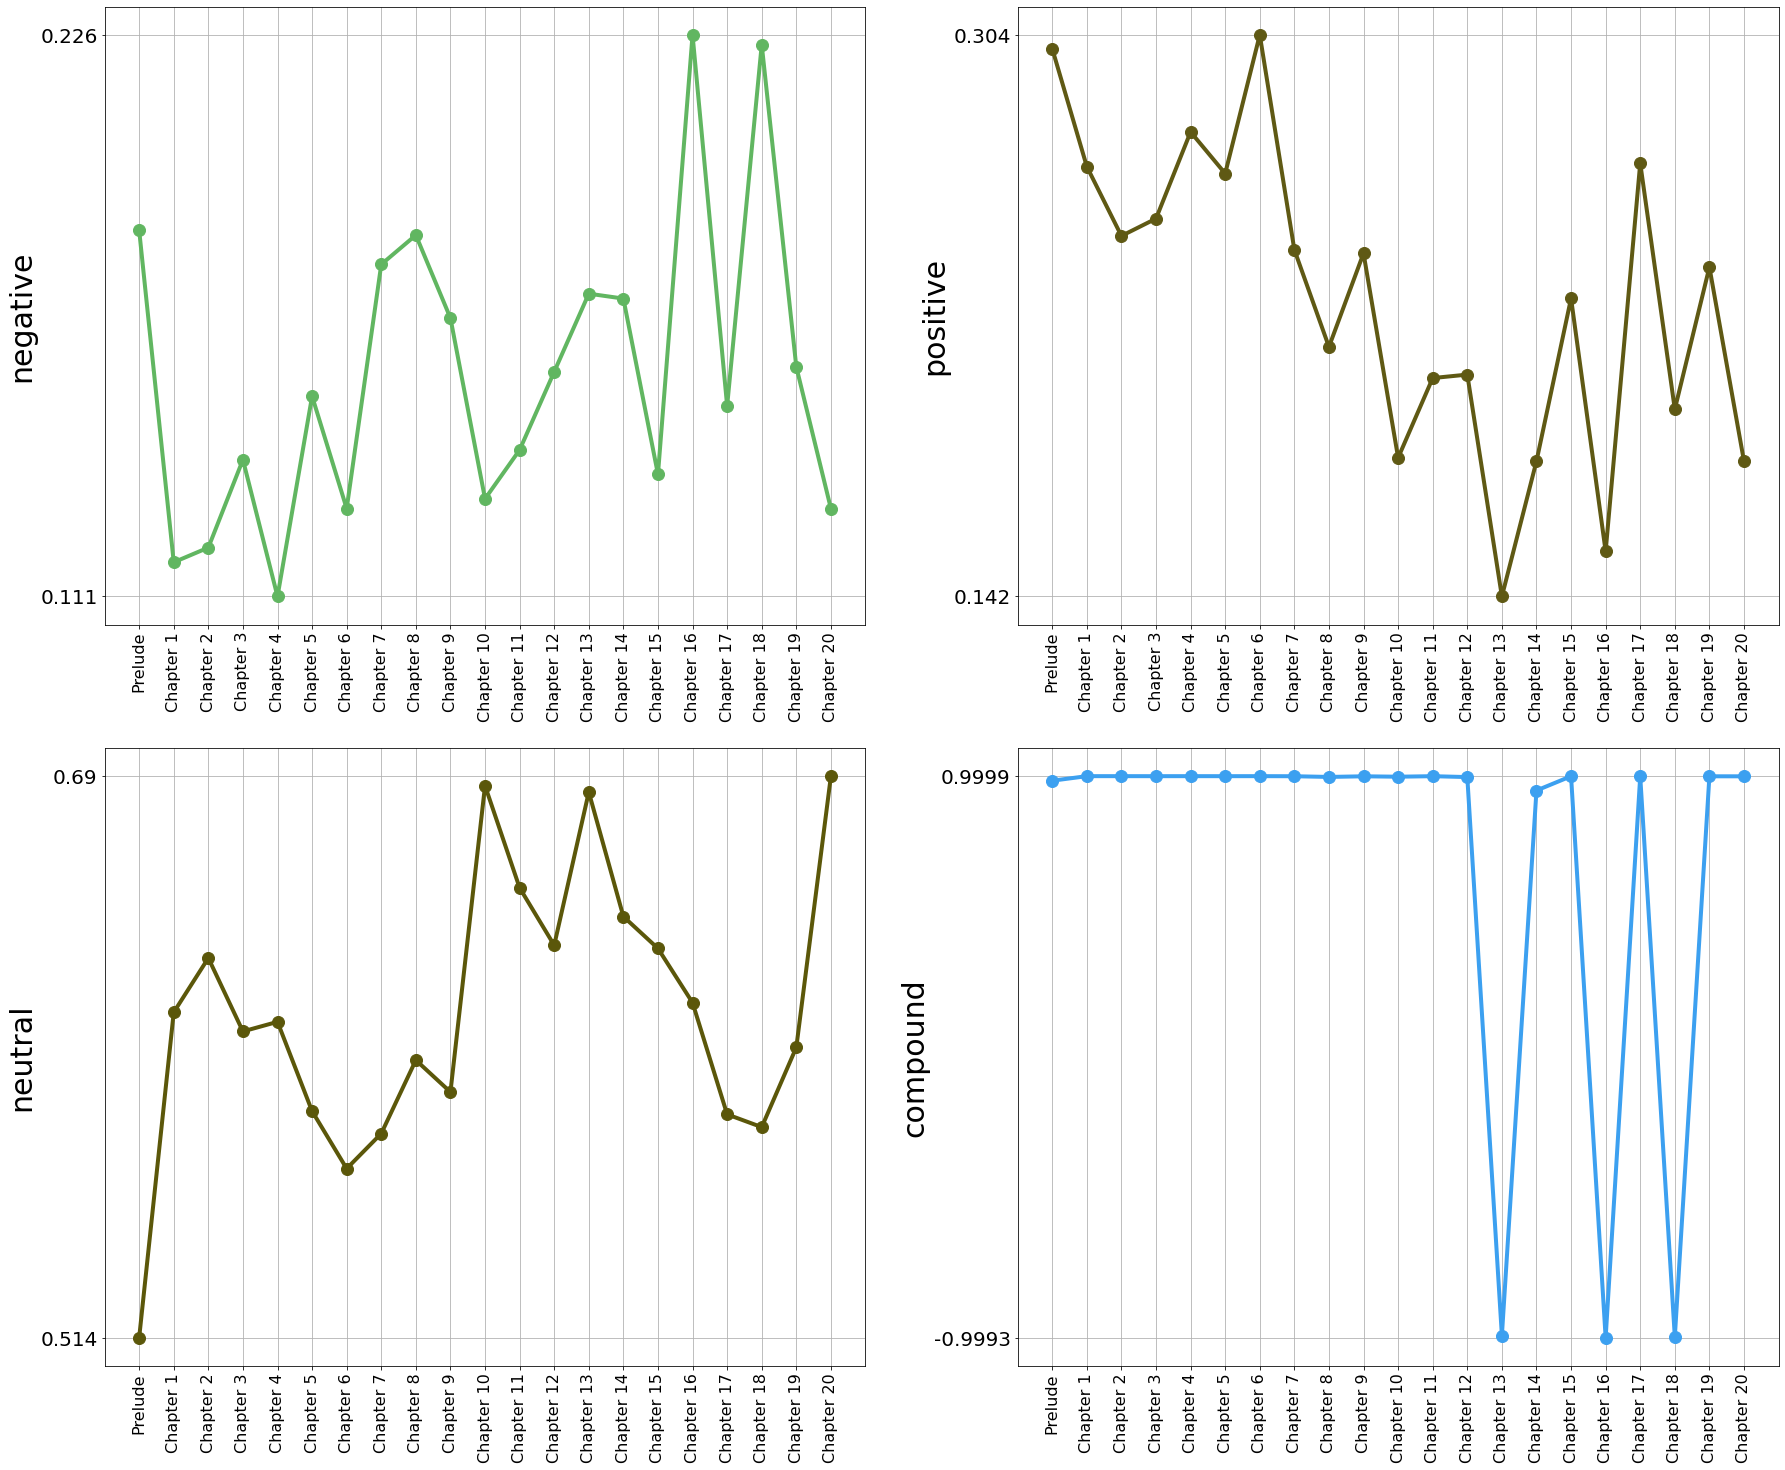

In [16]:
fig, axs = plt.subplots(2,2,figsize=(30,25))
# scatter plot
nRows = 2
nCols = 2
col_names = ['neg', 'neu', 'pos', 'compound']
axs_names = ['negative', 'neutral', 'positive', 'compound']
i = 0
j = 0
counter = 0
for val in range(len(col_names)):
    col_name = col_names[val]
    axs_name = axs_names[val]
    r = lambda: random.randint(0,255)
    hexcol = '#%02X%02X%02X' % (r(),r(),r())
    axs[i,j].plot(df_pos['Chapter_Name'], 
                  df_pos[col_name],
                  marker='o',  
                  markersize=12, 
                  linewidth=4,
                  color= hexcol)
    axs[i,j].set_xticks(df_pos['Chapter_Name'])
    axs[i,j].set_yticks([df_pos[col_name].min(), df_pos[col_name].max()],fontsize = 20)
    axs[i,j].set_xticklabels(df_pos['Chapter_Name'], rotation=90 , fontsize = 16)
    axs[i,j].set_yticklabels([df_pos[col_name].min(), df_pos[col_name].max()] , fontsize = 20)
    axs[i,j].set_ylabel(axs_name, fontsize = 30)
    axs[i,j].grid(True)
    if i < nRows-1:
        i += 1
    else:
        i = 0
        j += 1
    
plt.show()

## NRC Lexicon Categorization
Now let's try using the NRC lexicon which has 10 different emotions it can categorize text data into. The emotions are: joy, positive, anticipation, sadness, surprise, negative, andger, disgust, trust, and fear. The NRC lexicon is composed of over 27,000 words at the time of writing. You can find more info on the NRC lexicon here: <a href = "http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm">http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm</a>

To use it you need to first install it via <code>pip install NRCLex</code>

Then you can import it into your environment via <code>from nrclex import NRCLex</code>

In [17]:
text_object = NRCLex(df_pos['chapter_contents'][0])
scores = text_object.raw_emotion_scores
scores

{'joy': 23,
 'positive': 43,
 'anticipation': 18,
 'sadness': 22,
 'surprise': 13,
 'negative': 22,
 'anger': 10,
 'disgust': 5,
 'trust': 13,
 'fear': 4}

Let me start by calculating the raw emotion scores for each chapter and adding them into the dataframe. The result of this will give me the number of words in the chapter that are associated with one of the 10 emotions listed above.

In [18]:
df_pos['joy']          = [NRCLex(x).raw_emotion_scores['joy']          for x in df_pos['chapter_contents']]
df_pos['positive']     = [NRCLex(x).raw_emotion_scores['positive']     for x in df_pos['chapter_contents']]
df_pos['anticipation'] = [NRCLex(x).raw_emotion_scores['anticipation'] for x in df_pos['chapter_contents']]
df_pos['sadness']      = [NRCLex(x).raw_emotion_scores['sadness']      for x in df_pos['chapter_contents']]
df_pos['surprise']     = [NRCLex(x).raw_emotion_scores['surprise']     for x in df_pos['chapter_contents']]
df_pos['negative']     = [NRCLex(x).raw_emotion_scores['negative']     for x in df_pos['chapter_contents']]
df_pos['anger']        = [NRCLex(x).raw_emotion_scores['anger']        for x in df_pos['chapter_contents']]
df_pos['disgust']      = [NRCLex(x).raw_emotion_scores['disgust']      for x in df_pos['chapter_contents']]
df_pos['trust']        = [NRCLex(x).raw_emotion_scores['trust']        for x in df_pos['chapter_contents']]
df_pos['fear']         = [NRCLex(x).raw_emotion_scores['fear']         for x in df_pos['chapter_contents']]
df_pos

Book_ID Chapter_Name                                   chapter_contents  \
0      174      Prelude  preface artist creator beautiful thing reveal ...   
1      174    Chapter 1  studio fill rich odour rise light summer wind ...   
2      174    Chapter 2  enter saw dorian gray seat piano back turn pag...   
3      174    Chapter 3  half-past twelve next day lord henry wotton st...   
4      174    Chapter 4  one afternoon month late dorian gray recline l...   
5      174    Chapter 5  mother mother happy whisper girl bury face lap...   
6      174    Chapter 6  suppose hear news basil say lord henry even ha...   
7      174    Chapter 7  reason house crowd night fat jew manager meet ...   
8      174    Chapter 8  long past noon awake valet creep several time ...   
9      174    Chapter 9  sit breakfast next morning basil hallward show...   
10     174   Chapter 10  servant enter look steadfastly wonder think pe...   
11     174   Chapter 11  year dorian gray could free influence book per...   
12     174   Chapter 12  ninth november eve thirty-eighth birthday ofte...   
13     174   Chapter 13  pass room begin ascent basil hallward follow c...   
14     174   Chapter 14  nine clock next morning servant come cup choco...   
15     174   Chapter 15  evening eight-thirty exquisitely dress wear la...   
16     174   Chapter 16  cold rain begin fall blurred street-lamps look...   
17     174   Chapter 17  week late dorian gray sit conservatory selby r...   
18     174   Chapter 18  next day leave house indeed spend time room si...   
19     174   Chapter 19  use tell go good cry lord henry dip white fing...   
20     174   Chapter 20  lovely night warm throw coat arm even put silk...   

    compound    neg    neu    pos  joy  positive  anticipation  sadness  \
0     0.9837  0.186  0.514  0.300   23        43            18       22   
1     0.9999  0.118  0.616  0.266  163       335           144      133   
2     0.9999  0.121  0.633  0.246  172       329           138      170   
3     0.9998  0.139  0.610  0.251  159       352           138      137   
4     0.9999  0.111  0.613  0.276  191       354           178      167   
5     0.9998  0.152  0.585  0.264  189       310           170      135   
6     0.9999  0.129  0.567  0.304  131       217           100       67   
7     0.9996  0.179  0.578  0.242  167       264           117      139   
8     0.9971  0.185  0.601  0.214  153       303           155      189   
9     0.9994  0.168  0.591  0.241  102       197            92      127   
10    0.9979  0.131  0.687  0.182   57       147            63       94   
11    0.9998  0.141  0.655  0.205  244       500           228      209   
12    0.9966  0.157  0.637  0.206   67       135            58       59   
13   -0.9917  0.173  0.685  0.142   45        86            57       83   
14    0.9488  0.172  0.646  0.181   96       193           126      123   
15    0.9996  0.136  0.636  0.228   80       191            77       72   
16   -0.9993  0.226  0.619  0.155   68       133            90      128   
17    0.9992  0.150  0.584  0.267   64       114            59       67   
18   -0.9966  0.224  0.580  0.196   74       164            97      124   
19    0.9994  0.158  0.605  0.237  112       199            99      112   
20    0.9993  0.129  0.690  0.181   91       362           102       94   

    surprise  negative  anger  disgust  trust  fear  
0         13        22     10        5     13     4  
1         99       215     90      102    188    91  
2        109       283     94      137    188   125  
3         97       237     82       98    232    96  
4        111       237    104      104    171   102  
5        100       236     85       69    173   116  
6         57       136     51       54    153    52  
7         88       218     95      107    129   112  
8         99       286    113      100    165   159  
9         81       175     65       55    110    93  
10        38       162     52       74   

Nice! Now we have a lot more data to work with! Let's plot each of the sentiment frequencies for each of the chapters.

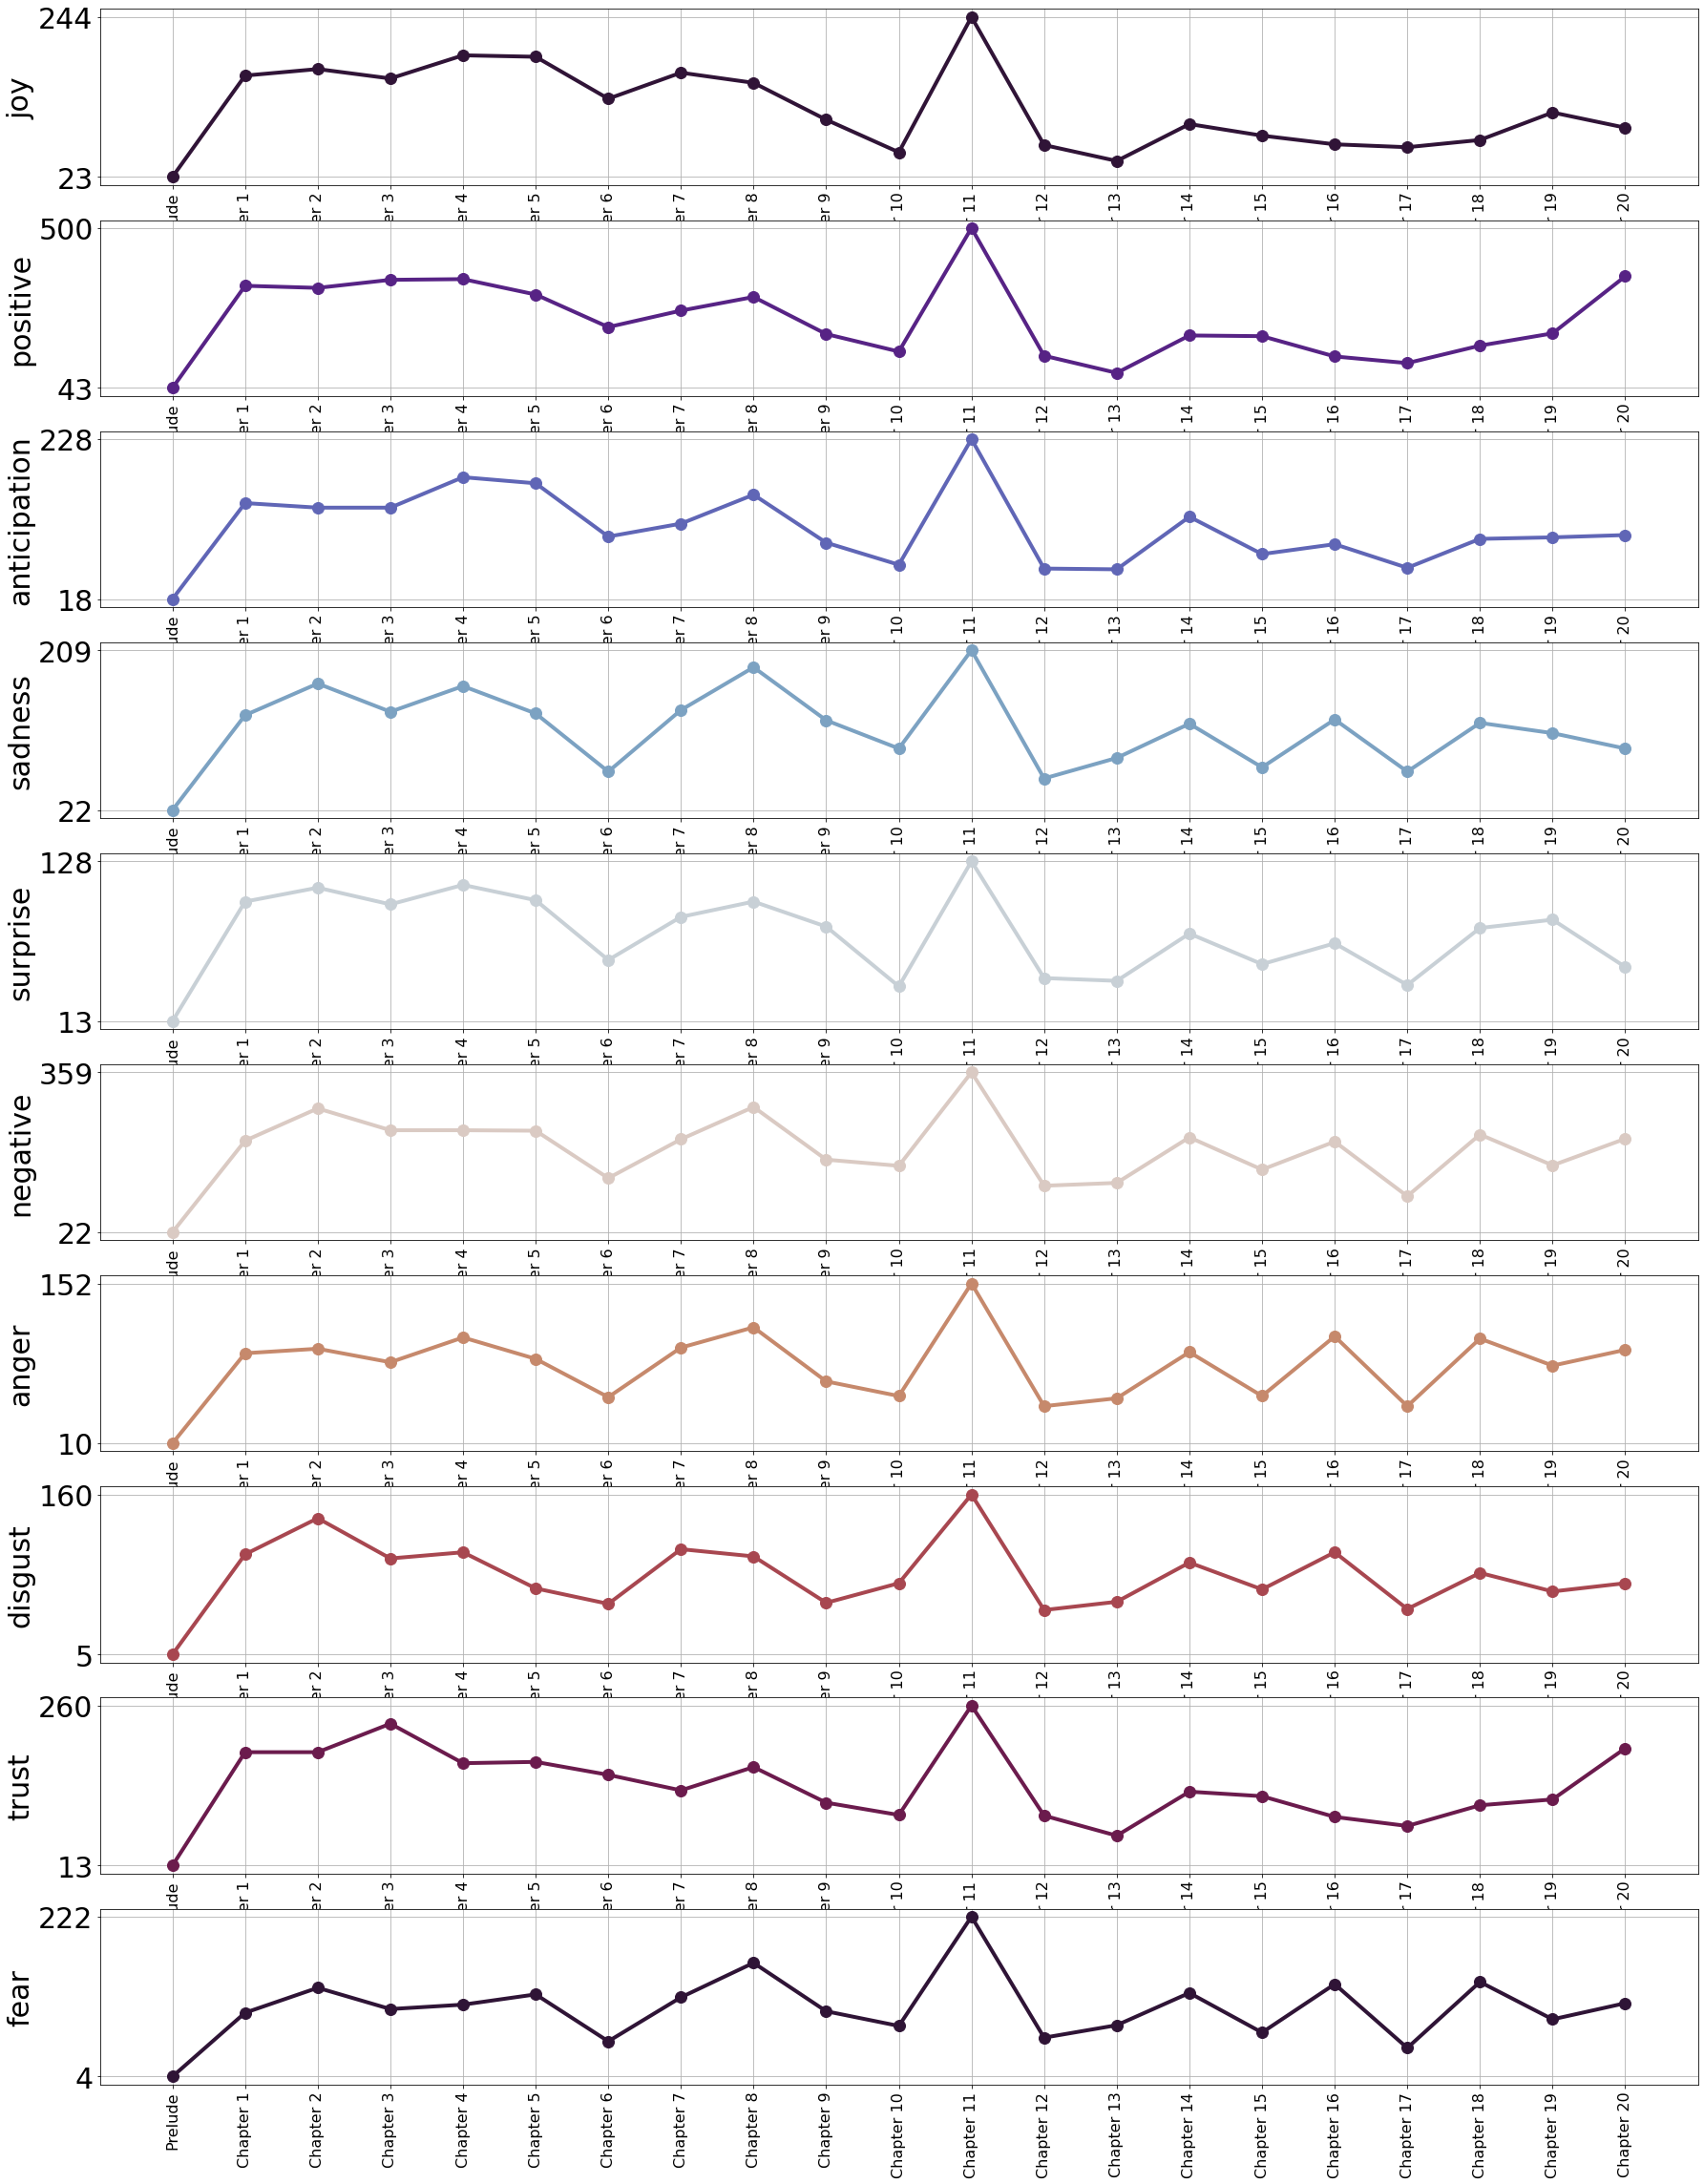

In [19]:
fig, axs = plt.subplots(10,1,figsize=(30,40))
# scatter plot
col_names = ['joy', 'positive', 'anticipation', 'sadness',
             'surprise', 'negative', 'anger', 'disgust', 'trust','fear']
i = 0
counter = 0

cmap = plt.cm.get_cmap('twilight_shifted')
slicedCM = cmap(np.linspace(0, 1, len(col_names))) 

for val in range(len(col_names)):
    col_name = col_names[val]
    #Make a random hex color
    r = lambda: random.randint(0,255)
    hexcol = '#%02X%02X%02X' % (r(),r(),r())
    axs[i].plot(df_pos['Chapter_Name'], 
                df_pos[col_name], 
                marker='o',  
                markersize=12, 
                linewidth=4,  
                color= slicedCM[val])
    axs[i].set_xticks(df_pos['Chapter_Name'])
    axs[i].set_yticks([df_pos[col_name].min(), df_pos[col_name].max()],fontsize = 20)
    axs[i].set_xticklabels(df_pos['Chapter_Name'], rotation=90 , fontsize = 16)
    axs[i].set_yticklabels([df_pos[col_name].min(), df_pos[col_name].max()] , fontsize = 30)
    axs[i].set_ylabel(col_name, fontsize = 30)
    axs[i].grid(True)
    i+=1
plt.show()

Hmm, interesting... the overall line shape for the sentiments looks pretty close to one another throughout the book. There is a spike in emotion happening for Chapter 11 however. Why? I wonder if it's as simple of an explanation as Chapter 11 being significantly longer than all the other chapters. Let's see...

In [20]:
chap_word_count = []
for i in range(df_pos.shape[0]):
    chapter_name = df_pos['Chapter_Name'][i]
    word_count   = len(df_pos['chapter_contents'][i].split())
    chap_word_count.append(word_count)
    print(chapter_name, ' has ', word_count, ' words')

max_words = max(chap_word_count)
max_index = chap_word_count.index(max_words)
max_chap  = df_pos['Chapter_Name'][max_index]
print('The chapter with the most words has ',max_words, ' words')
print('The chapter with the most words is at index ', max_index)
print('The chapter with the most words is ', max_chap)

Prelude  has  181  words
Chapter 1  has  2276  words
Chapter 2  has  2607  words
Chapter 3  has  2196  words
Chapter 4  has  2591  words
Chapter 5  has  2014  words
Chapter 6  has  1325  words
Chapter 7  has  2042  words
Chapter 8  has  2387  words
Chapter 9  has  1686  words
Chapter 10  has  1523  words
Chapter 11  has  3612  words
Chapter 12  has  1173  words
Chapter 13  has  1167  words
Chapter 14  has  2108  words
Chapter 15  has  1579  words
Chapter 16  has  1527  words
Chapter 17  has  881  words
Chapter 18  has  1581  words
Chapter 19  has  1609  words
Chapter 20  has  2501  words
The chapter with the most words has  3612  words
The chapter with the most words is at index  11
The chapter with the most words is  Chapter 11


Indeed. Chapter 11 is longer than all the other chapters and as such its word count is inflating the results. I will repeat the analysis but I will normalize the results by the chapter word count and see if that changes things.
I'll start by adding a chapter word count column at the end of the dataframe

In [21]:
df_pos.insert(loc=len(df_pos.columns), column='Chapter_WC', value = chap_word_count)
df_pos.head()

Book_ID Chapter_Name                                   chapter_contents  \
0     174      Prelude  preface artist creator beautiful thing reveal ...   
1     174    Chapter 1  studio fill rich odour rise light summer wind ...   
2     174    Chapter 2  enter saw dorian gray seat piano back turn pag...   
3     174    Chapter 3  half-past twelve next day lord henry wotton st...   
4     174    Chapter 4  one afternoon month late dorian gray recline l...   

   compound    neg    neu    pos  joy  positive  anticipation  sadness  \
0    0.9837  0.186  0.514  0.300   23        43            18       22   
1    0.9999  0.118  0.616  0.266  163       335           144      133   
2    0.9999  0.121  0.633  0.246  172       329           138      170   
3    0.9998  0.139  0.610  0.251  159       352           138      137   
4    0.9999  0.111  0.613  0.276  191       354           178      167   

   surprise  negative  anger  disgust  trust  fear  Chapter_WC  
0        13        22     10        5     13     4         181  
1        99       215     90      102    188    91        2276  
2       109       283     94      137    188   125        2607  
3        97       237     82       98    232    96        2196  
4       111       237    104      104    171   102        2591

And now, I'll generate new columns with the chapter word_count normalized values. 

In [22]:
df_pos['joy_n']          = df_pos['joy']/df_pos['Chapter_WC']
df_pos['positive_n']     = df_pos['positive']/df_pos['Chapter_WC']
df_pos['anticipation_n'] = df_pos['anticipation']/df_pos['Chapter_WC']
df_pos['sadness_n']      = df_pos['sadness']/df_pos['Chapter_WC']
df_pos['surprise_n']     = df_pos['surprise']/df_pos['Chapter_WC']
df_pos['negative_n']     = df_pos['negative']/df_pos['Chapter_WC']
df_pos['anger_n']        = df_pos['anger']/df_pos['Chapter_WC']
df_pos['disgust_n']      = df_pos['disgust']/df_pos['Chapter_WC']
df_pos['trust_n']        = df_pos['trust']/df_pos['Chapter_WC']
df_pos['fear_n']         = df_pos['fear']/df_pos['Chapter_WC']
df_pos.head()

Book_ID Chapter_Name                                   chapter_contents  \
0     174      Prelude  preface artist creator beautiful thing reveal ...   
1     174    Chapter 1  studio fill rich odour rise light summer wind ...   
2     174    Chapter 2  enter saw dorian gray seat piano back turn pag...   
3     174    Chapter 3  half-past twelve next day lord henry wotton st...   
4     174    Chapter 4  one afternoon month late dorian gray recline l...   

   compound    neg    neu    pos  joy  positive  anticipation  ...     joy_n  \
0    0.9837  0.186  0.514  0.300   23        43            18  ...  0.127072   
1    0.9999  0.118  0.616  0.266  163       335           144  ...  0.071617   
2    0.9999  0.121  0.633  0.246  172       329           138  ...  0.065976   
3    0.9998  0.139  0.610  0.251  159       352           138  ...  0.072404   
4    0.9999  0.111  0.613  0.276  191       354           178  ...  0.073717   

   positive_n  anticipation_n  sadness_n  surprise_n  negative_n   anger_n  \
0    0.237569        0.099448   0.121547    0.071823    0.121547  0.055249   
1    0.147188        0.063269   0.058436    0.043497    0.094464  0.039543   
2    0.126199        0.052934   0.065209    0.041811    0.108554  0.036057   
3    0.160291        0.062842   0.062386    0.044171    0.107923  0.037341   
4    0.136627        0.068699   0.064454    0.042841    0.091470  0.040139   

   disgust_n   trust_n    fear_n  
0   0.027624  0.071823  0.022099  
1   0.044815  0.082601  0.039982  
2   0.052551  0.072114  0.047948  
3   0.044627  0.105647  0.043716  
4   0.040139  0.065998  0.039367  

[5 rows x 28 columns]

Let me plot these results now and see what's up

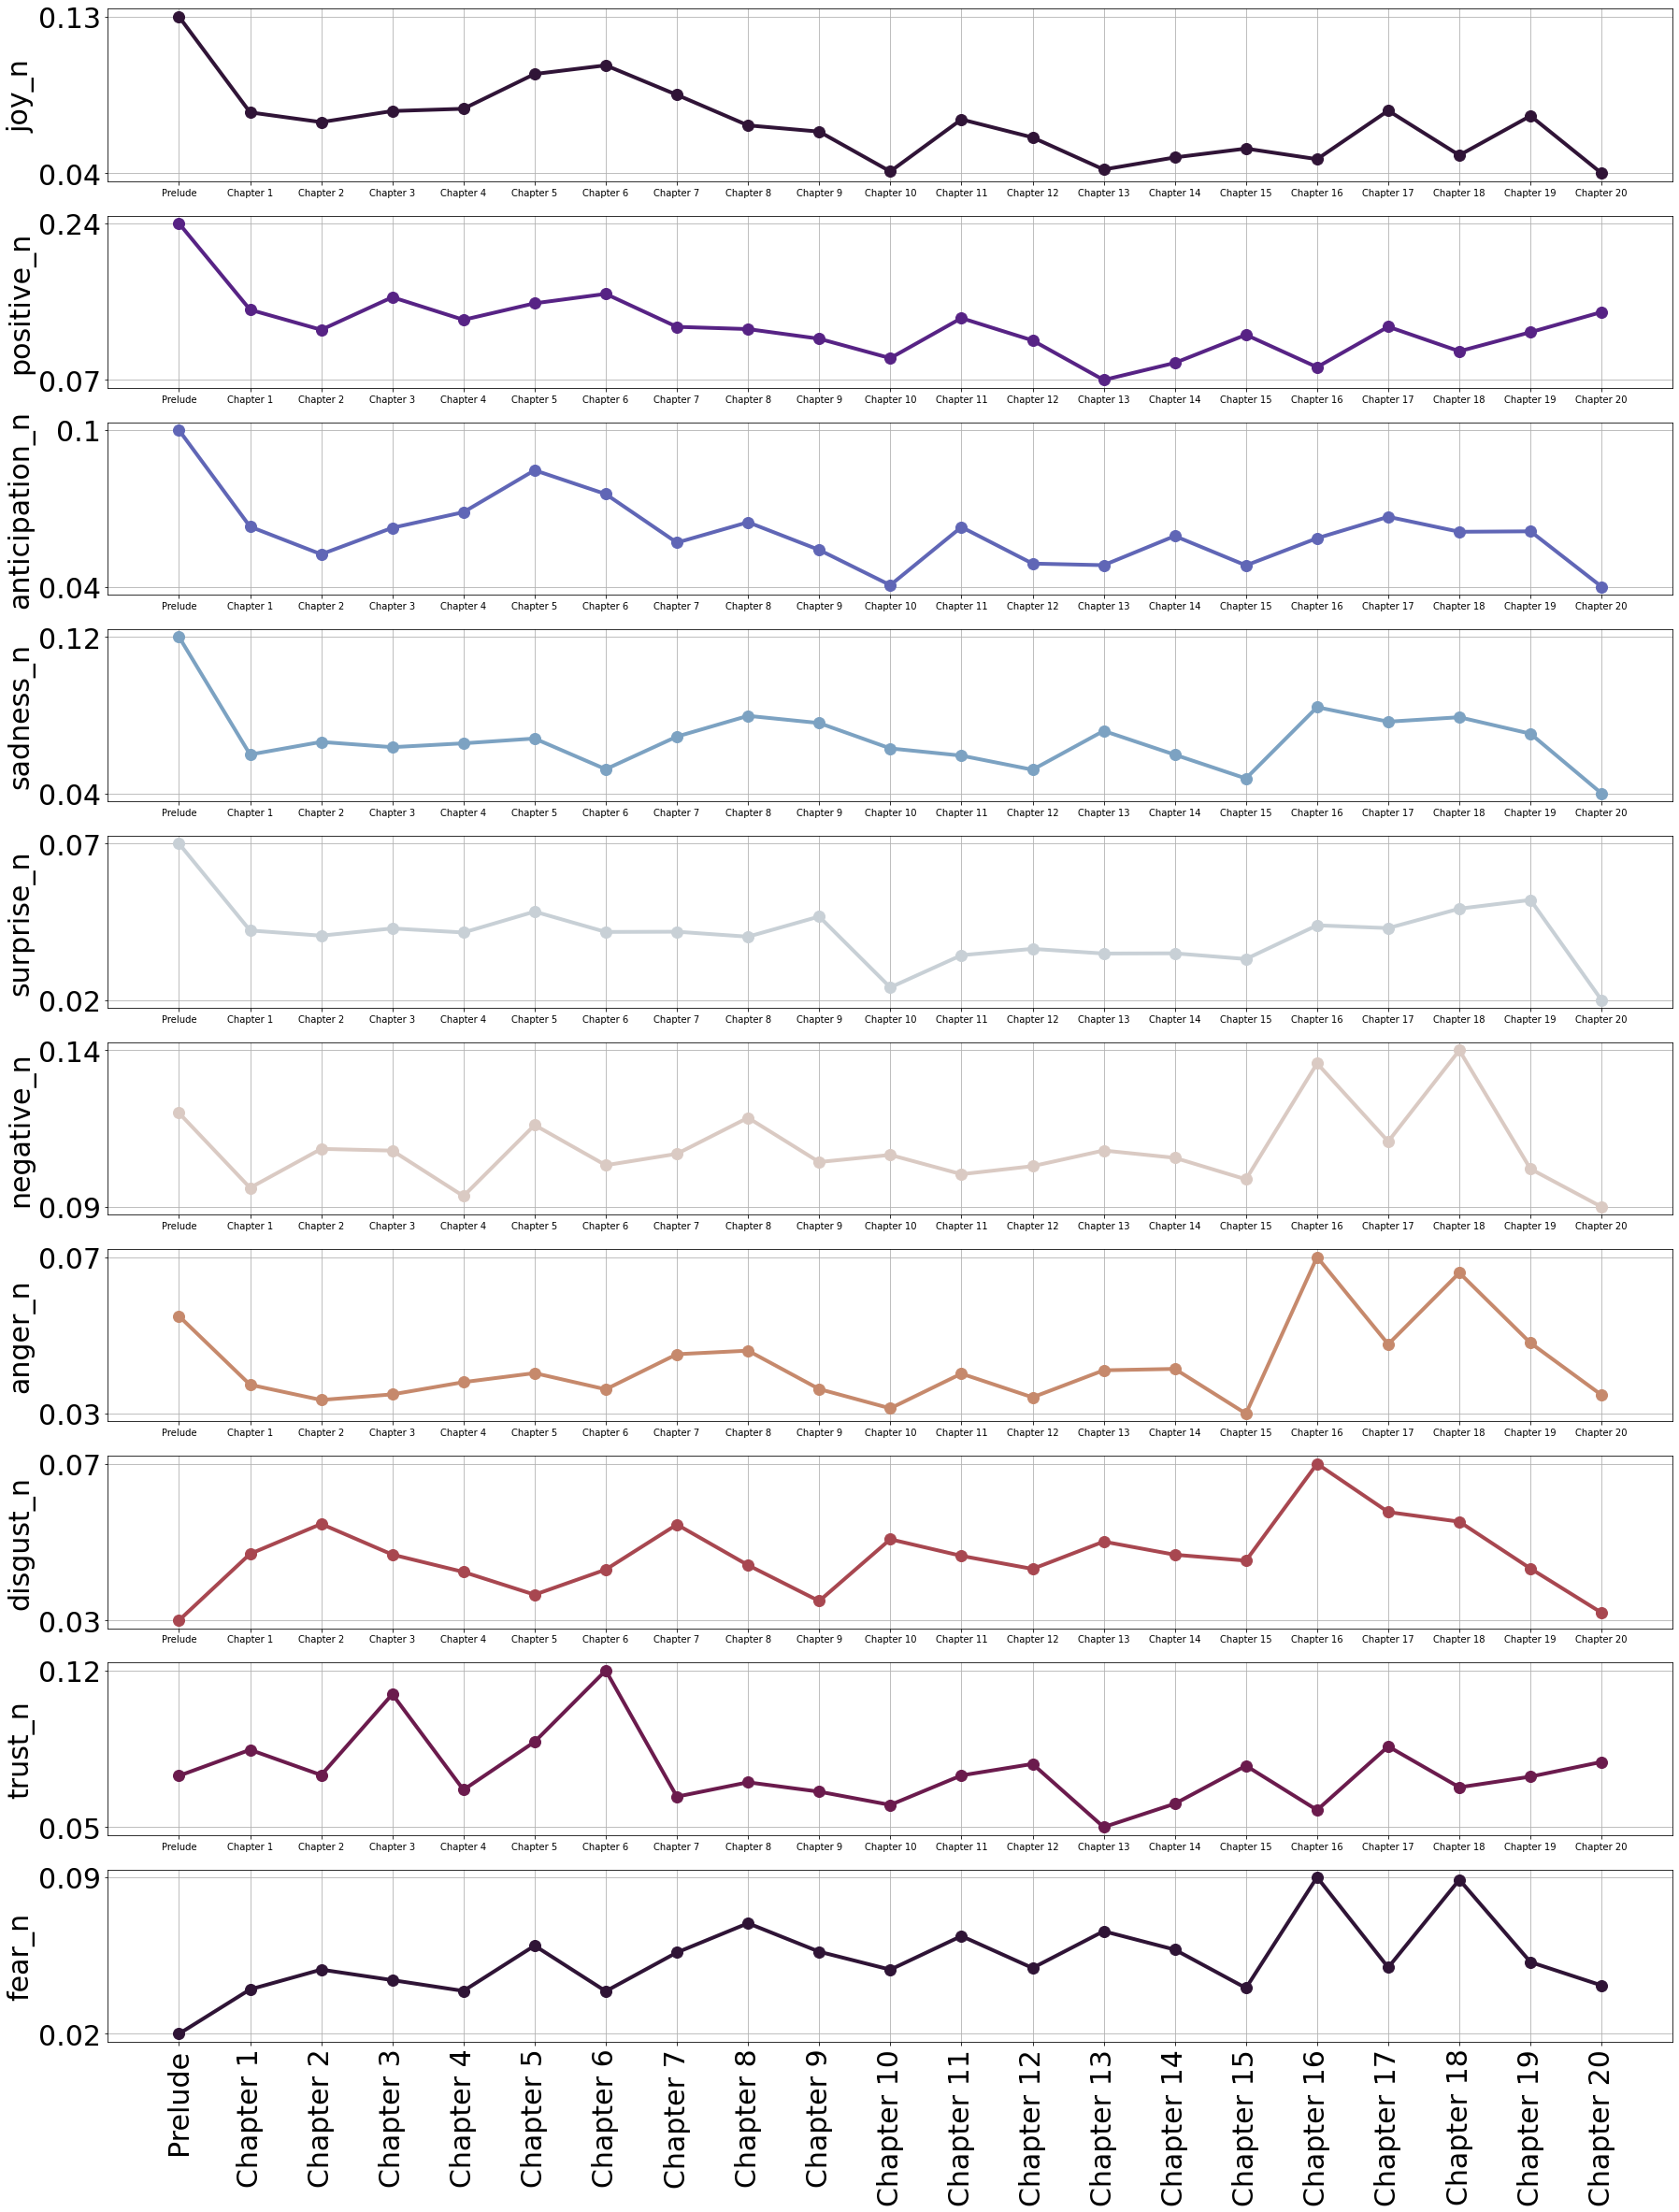

In [23]:
import numpy as np
fig, axs = plt.subplots(10,1,figsize=(30,40))
# scatter plot
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']
i = 0
counter = 0


cmap = plt.cm.get_cmap('twilight_shifted')
slicedCM = cmap(np.linspace(0, 1, len(col_names))) 

for val in range(len(col_names)):
    col_name = col_names[val]
    #Make a random hex color
    #r = lambda: random.randint(0,255)
    #hexcol = '#%02X%02X%02X' % (r(),r(),r())
    axs[i].plot(df_pos['Chapter_Name'], 
                df_pos[col_name], 
                marker='o',  
                markersize=12, 
                linewidth=4,  
                color= slicedCM[val])

    axs[i].set_yticks([df_pos[col_name].min(), df_pos[col_name].max()],fontsize = 20)
    axs[i].set_yticklabels(np.round([df_pos[col_name].min(), df_pos[col_name].max()],2) , fontsize = 30)
    axs[i].set_ylabel(col_name, fontsize = 30)
    axs[i].grid(True)
    i+=1
axs[i-1].set_xticks(df_pos['Chapter_Name'])
axs[i-1].set_xticklabels(df_pos['Chapter_Name'], rotation=90 , fontsize = 30)
plt.show()

That's pretty interesting! The different emotions have different behaviors over the course of the book! Are they somehow related? Let me generate a Pairplot from these results before discussing them further. I'll generate a new dataframe from the main dataframe that will contain the results from the NRC lexicon emotion analysis.

In [166]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']
df_pos_nrc = df_pos[col_names]
#df_pos_nrc.insert(0, column='Chapter_Name', value = df_pos['Chapter_Name'])
df_pos_nrc.head()

joy_n  positive_n  anticipation_n  sadness_n  surprise_n  negative_n  \
0  0.127072    0.237569        0.099448   0.121547    0.071823    0.121547   
1  0.071617    0.147188        0.063269   0.058436    0.043497    0.094464   
2  0.065976    0.126199        0.052934   0.065209    0.041811    0.108554   
3  0.072404    0.160291        0.062842   0.062386    0.044171    0.107923   
4  0.073717    0.136627        0.068699   0.064454    0.042841    0.091470   

    anger_n  disgust_n   trust_n    fear_n  
0  0.055249   0.027624  0.071823  0.022099  
1  0.039543   0.044815  0.082601  0.039982  
2  0.036057   0.052551  0.072114  0.047948  
3  0.037341   0.044627  0.105647  0.043716  
4  0.040139   0.040139  0.065998  0.039367

And now, I'll generate the Pairplot

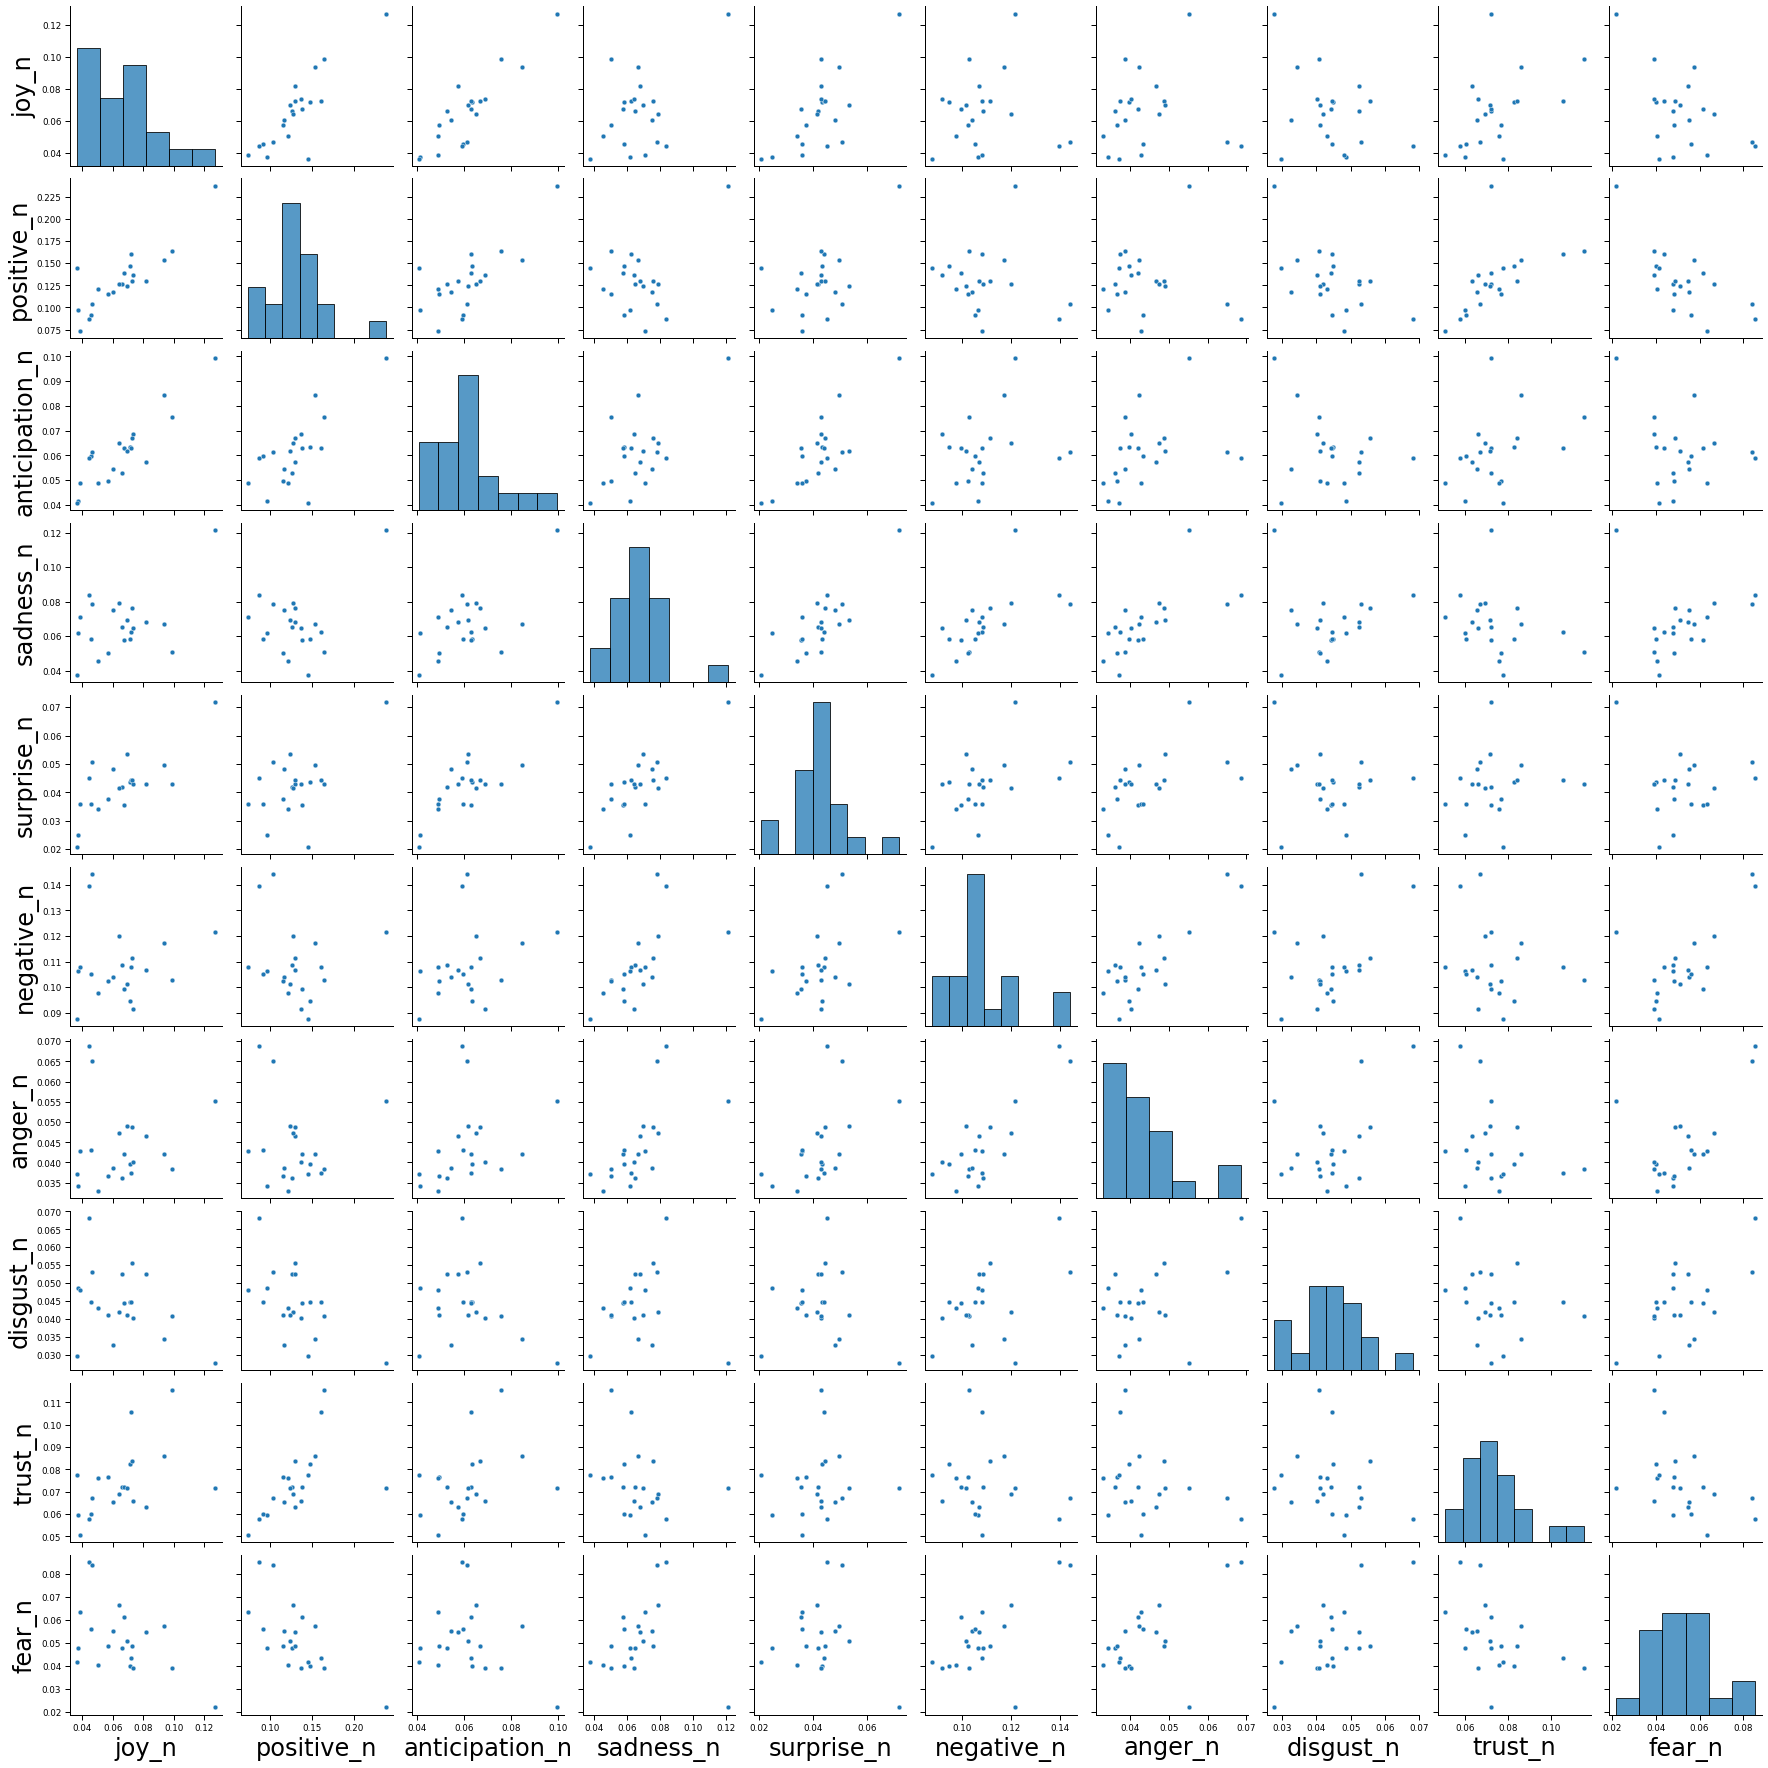

In [168]:
sns.set_context("paper", rc={"axes.labelsize":24})
sns.pairplot(df_pos_nrc, height=2.5)

Neat! Some of the emotions seem to be related to one another! For instance, the joy and positive scores are correlated to one another which makes sense. The disgust and fear scores on the other hand seem to be anti-correlated to the joy score. Let me generate the correlation matrix for these emotions to be sure.


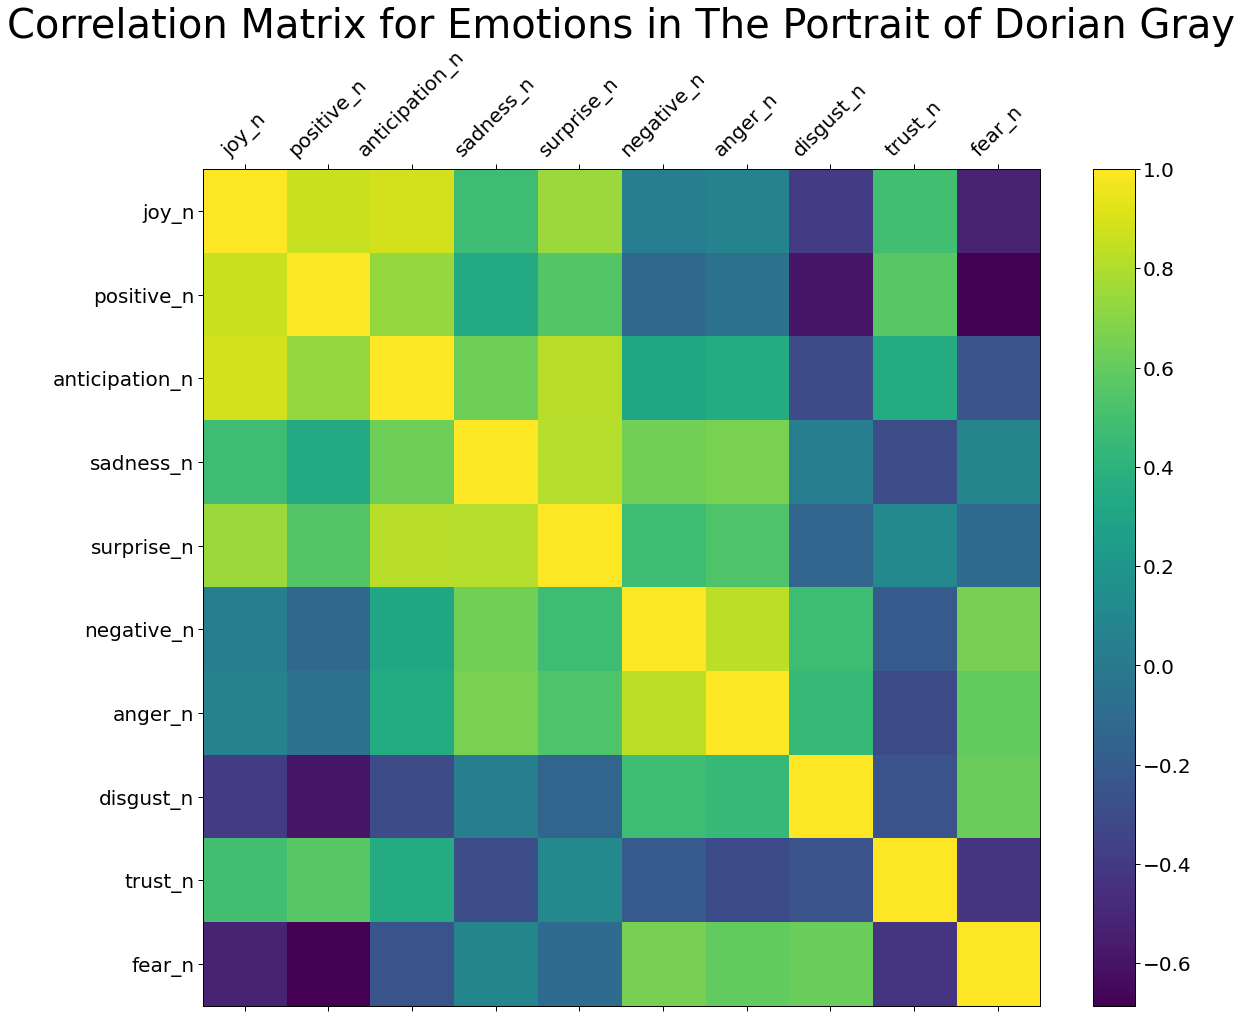

In [225]:
f = plt.figure(figsize=(19, 15))
fignum=f.number
plt.matshow(df_pos_nrc.corr(), fignum=f.number)
plt.xticks(range(df_pos_nrc.select_dtypes(['number']).shape[1]),
           df_pos_nrc.select_dtypes(['number']).columns,
           fontsize=20,
           rotation=45)
plt.yticks(range(df_pos_nrc.select_dtypes(['number']).shape[1]),
           df_pos_nrc.select_dtypes(['number']).columns, 
           fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.title('Correlation Matrix for Emotions in The Portrait of Dorian Gray', fontsize=40)
plt.show()

The correlation matrix shows how correlated the emotion scores are to one another. The values range from +1 (signifying high <strong>positive</strong> correlation) and -1 (signifying high <strong>negative</strong> correlation). When the color is brighter (more yellow), the two emotions being compared are more closely associated to one another. When the color is darker (more purple), the two emotions being compared are more distant to one another. 

From this matrix we can see which emotions are most/least closely related to one another in 'The Portrait of Dorian Gray'. For instance, joy seems to be very closely related to anticipation while fear is the most distant emotion to joy.  Disgust and Fear seem to be the antithesis of positive emotions in this book which I would argue are thematically accurate given the repulsion and fear that Dorian Gray experiences over the course of the book due to the nature of his persona and the events that unfolded which are made physically manifest through the painting that Basil made of him.
## Discussion of Results
Let's start looking at the behavior of each of the emotions measured over the course of the book.

I'll be displaying results using the 'plasma' color palette shown below where the change in color signifies book progression. For each emotion I'll also be plotting the relationship between it and the two emotions most similar/dissimilar to it.

### Joy
Joy is defined as 'a feeling of great pleasure and happiness'. Joy appears to have a fairly consistent downward trend over the course of the book. It has an approximately positive linear relationship with the positive sentiment and an approximately negative linear relationship with fear.

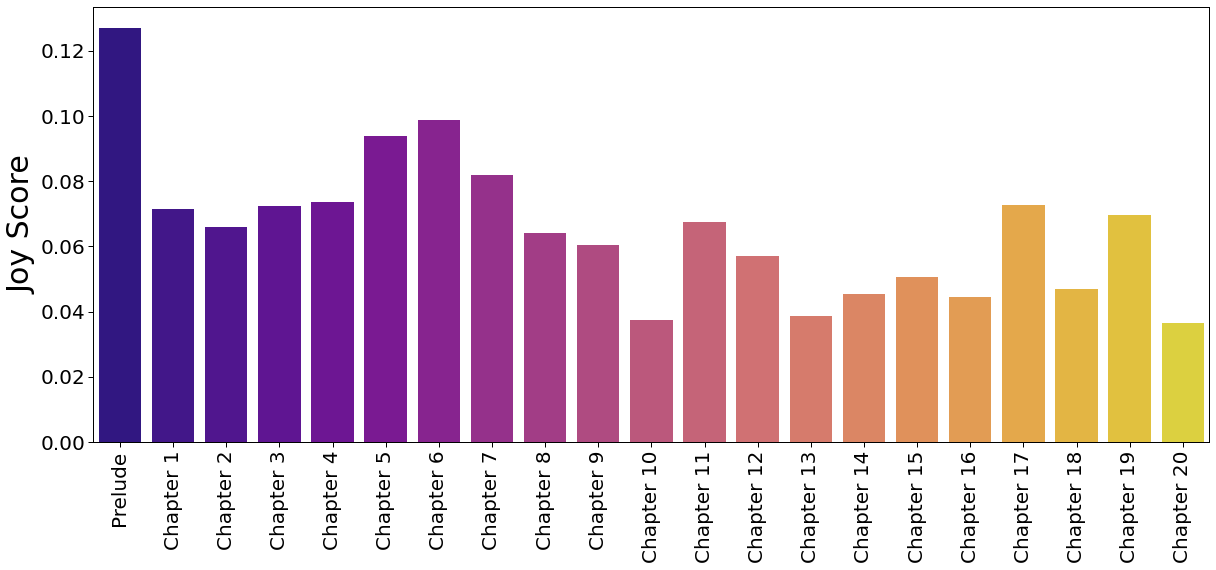

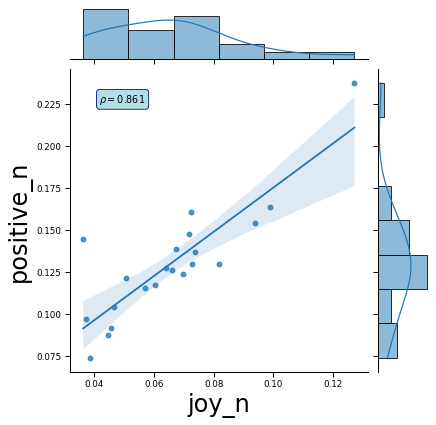

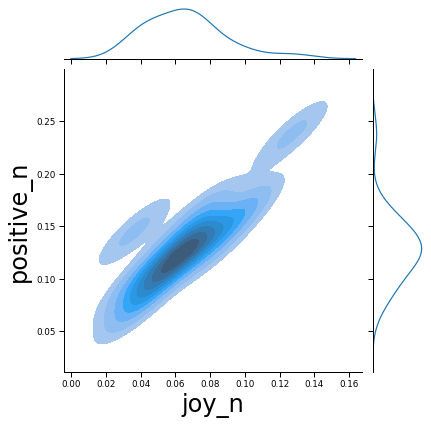

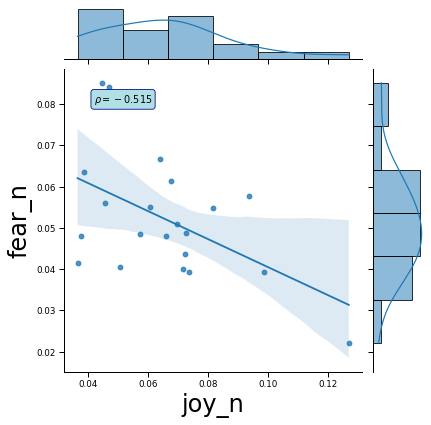

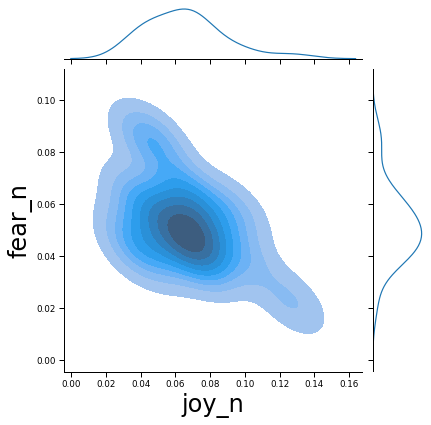

In [198]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['joy_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Joy Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['joy_n'], df_pos['positive_n'])
a0 = sns.jointplot(x="joy_n", y="positive_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="joy_n", y="positive_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['joy_n'], df_pos['fear_n'])
a2 = sns.jointplot(x="joy_n", y="fear_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="joy_n", y="fear_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Positive
Positive sentiments are defined as 'a good, affirmative, or constructive quality or attribute'. Positive sentiments also appear to have a downward trend for the first 13 chapters of the book. After that however, the positive sentiments start to trend upwards but they never reach the initial levels. 

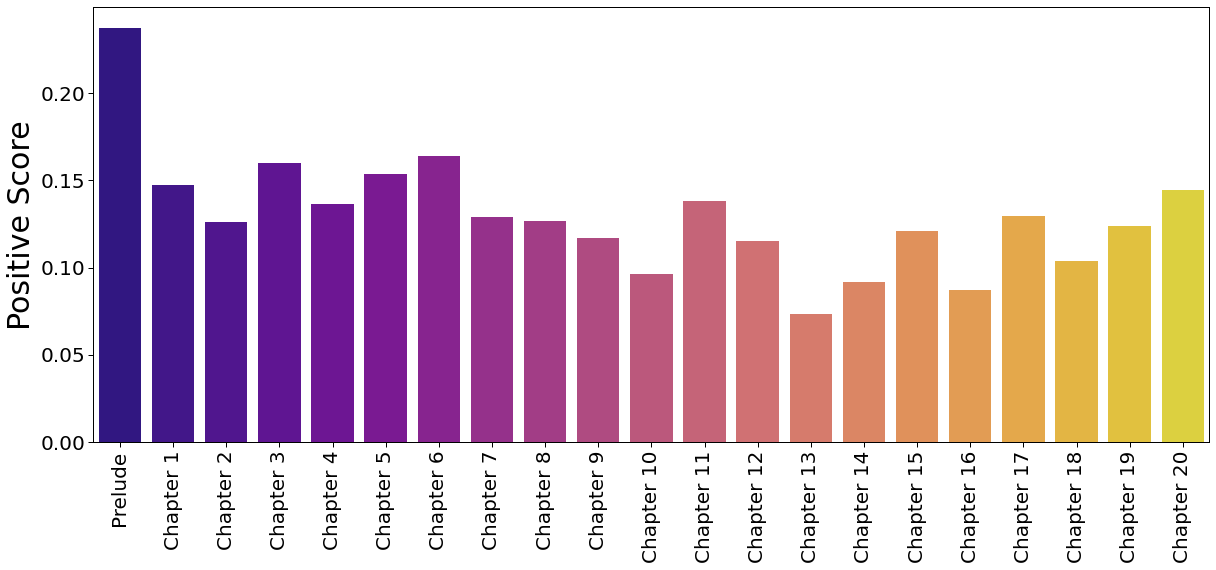

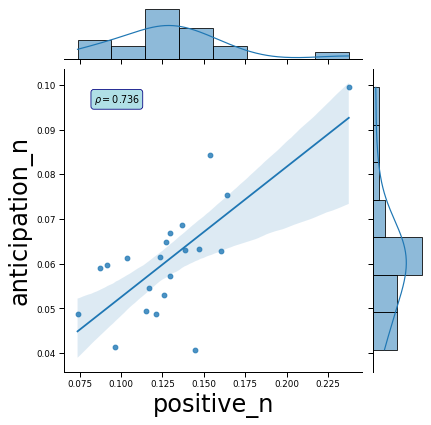

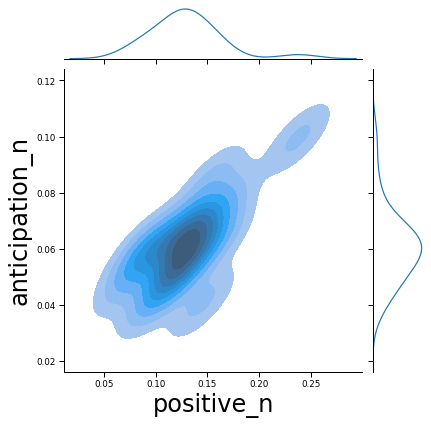

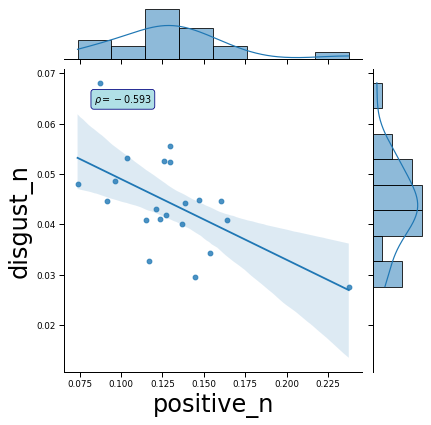

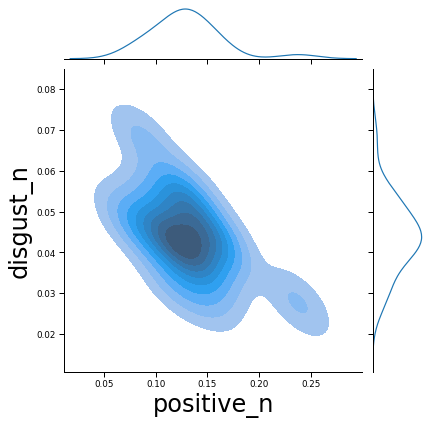

In [199]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['positive_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Positive Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['positive_n'], df_pos['anticipation_n'])
a0 = sns.jointplot(x="positive_n", y="anticipation_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="positive_n", y="anticipation_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['positive_n'], df_pos['disgust_n'])
a2 = sns.jointplot(x="positive_n", y="disgust_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="positive_n", y="disgust_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Anticipation
Anticipation is defined as 'excitement about something that's going to happen'. Anticipation appears to behave in an oscillatory fashion. However, each 'anticipation peak' is less strong than the last.

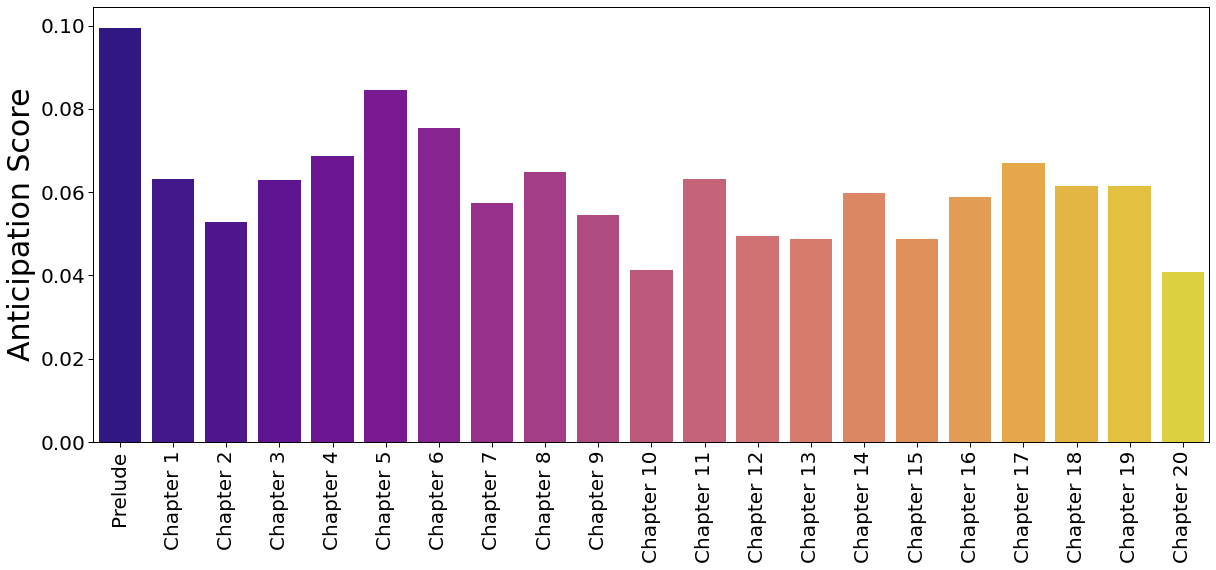

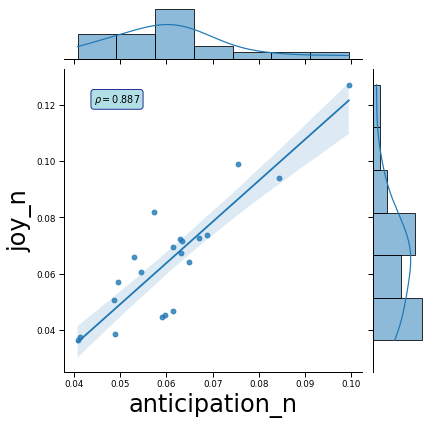

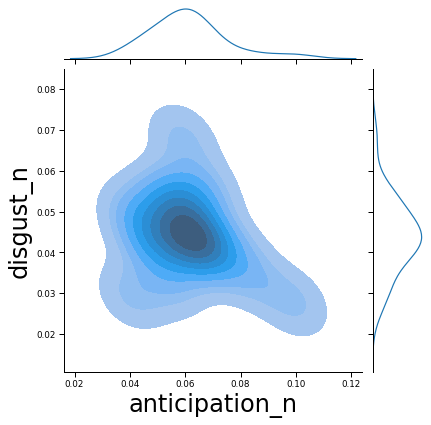

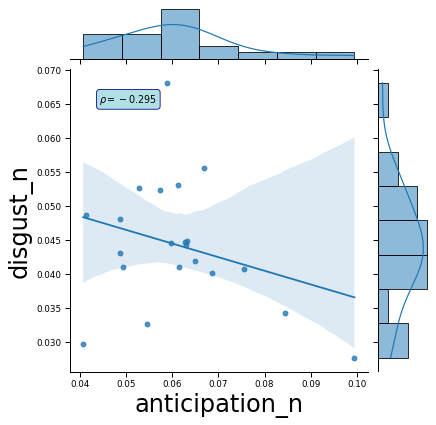

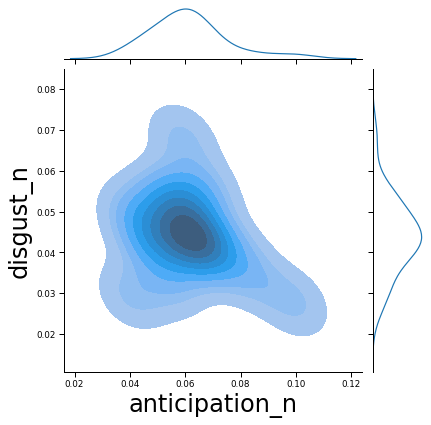

In [200]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['anticipation_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Anticipation Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['anticipation_n'], df_pos['joy_n'])
a0 = sns.jointplot(x="anticipation_n", y="joy_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="anticipation_n", y="disgust_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['anticipation_n'], df_pos['disgust_n'])
a2 = sns.jointplot(x="anticipation_n", y="disgust_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="anticipation_n", y="disgust_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Sadness
Sadness is defined as 'an emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment and sorrow'. Sadness remains fairly consistent over the course of the book. It does seem to trend downwards at the end.

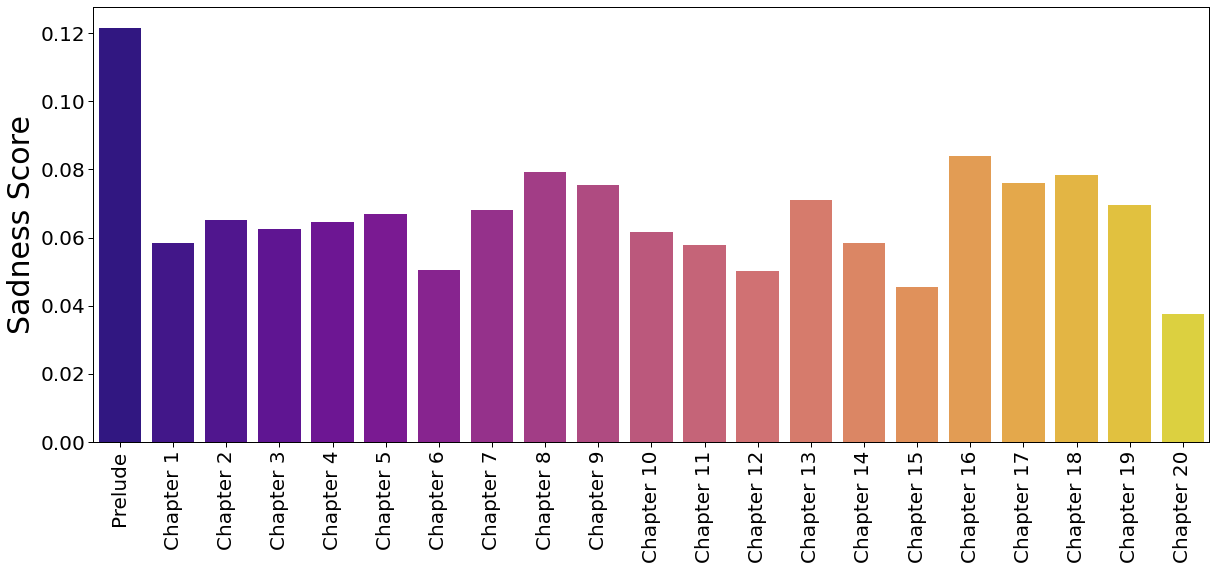

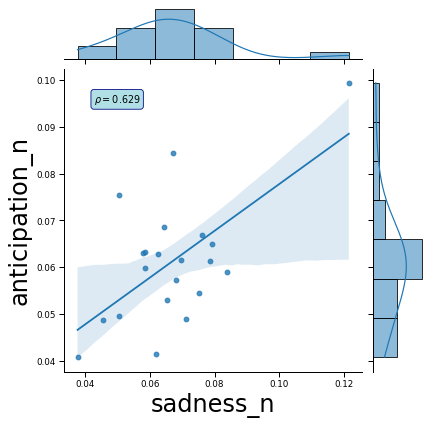

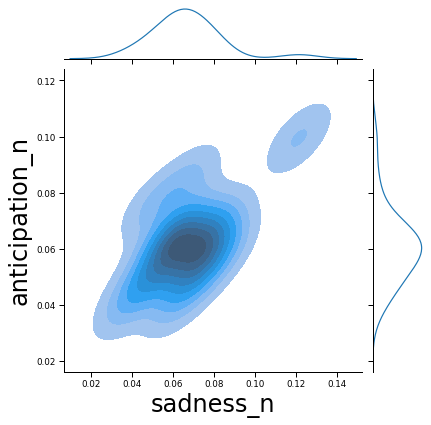

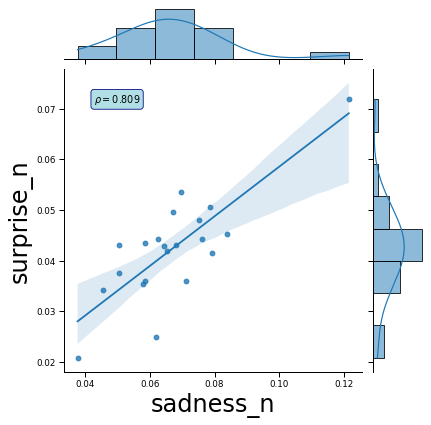

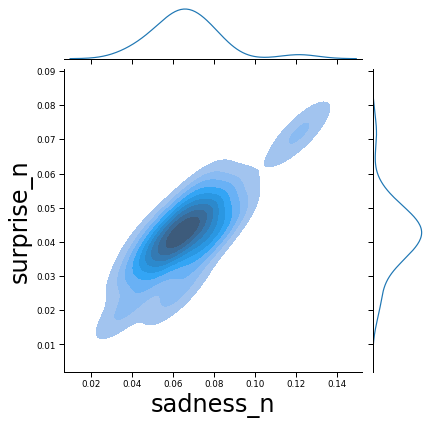

In [203]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['sadness_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Sadness Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['sadness_n'], df_pos['anticipation_n'])
a0 = sns.jointplot(x="sadness_n", y="anticipation_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="sadness_n", y="anticipation_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['sadness_n'], df_pos['surprise_n'])
a2 = sns.jointplot(x="sadness_n", y="surprise_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="sadness_n", y="surprise_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Surprise
Surprise is defined as 'to cause to feel wonder or amazement because of being unexpected'. Surprise also behaves in a very similar way to sadness within the context of this book.

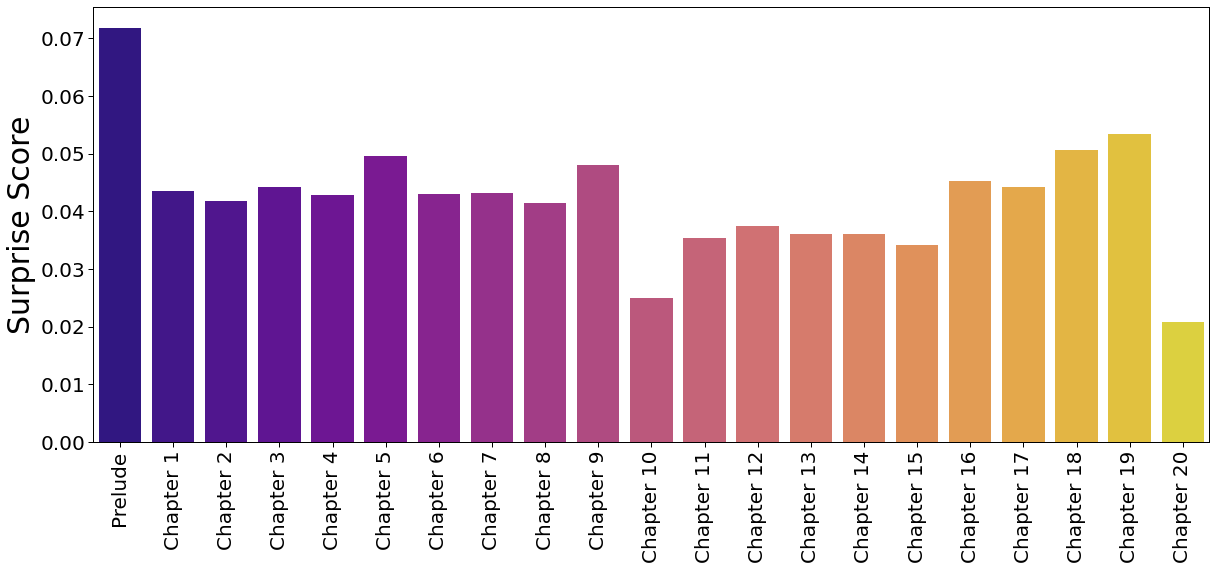

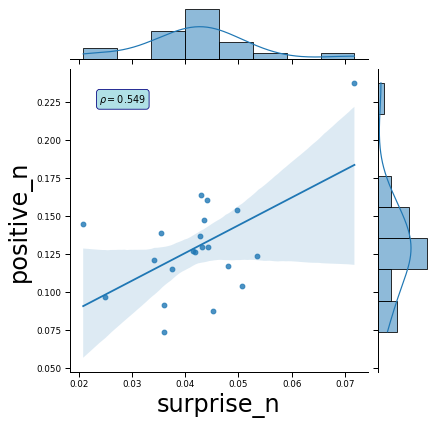

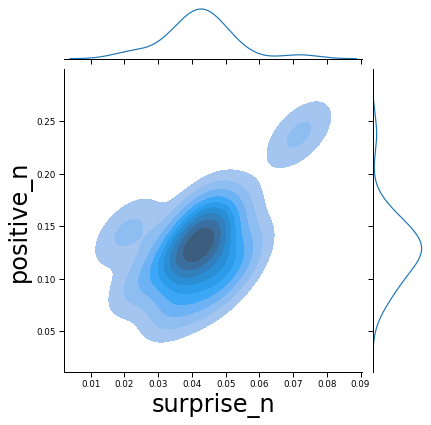

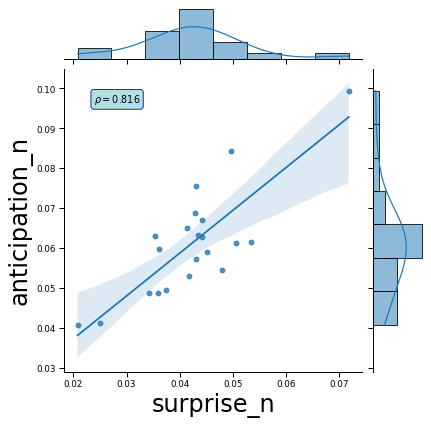

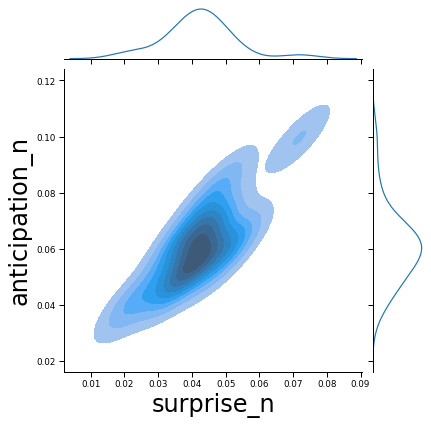

In [202]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['surprise_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Surprise Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['surprise_n'], df_pos['positive_n'])
a0 = sns.jointplot(x="surprise_n", y="positive_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="surprise_n", y="positive_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['surprise_n'], df_pos['anticipation_n'])
a2 = sns.jointplot(x="surprise_n", y="anticipation_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="surprise_n", y="anticipation_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Negative
Negative is defined as 'marked by absence, withholding, or removal of something positive '. Negative sentiments start relatively low and remains steady until it peaks in Chapters 16 and 18 before decaying again

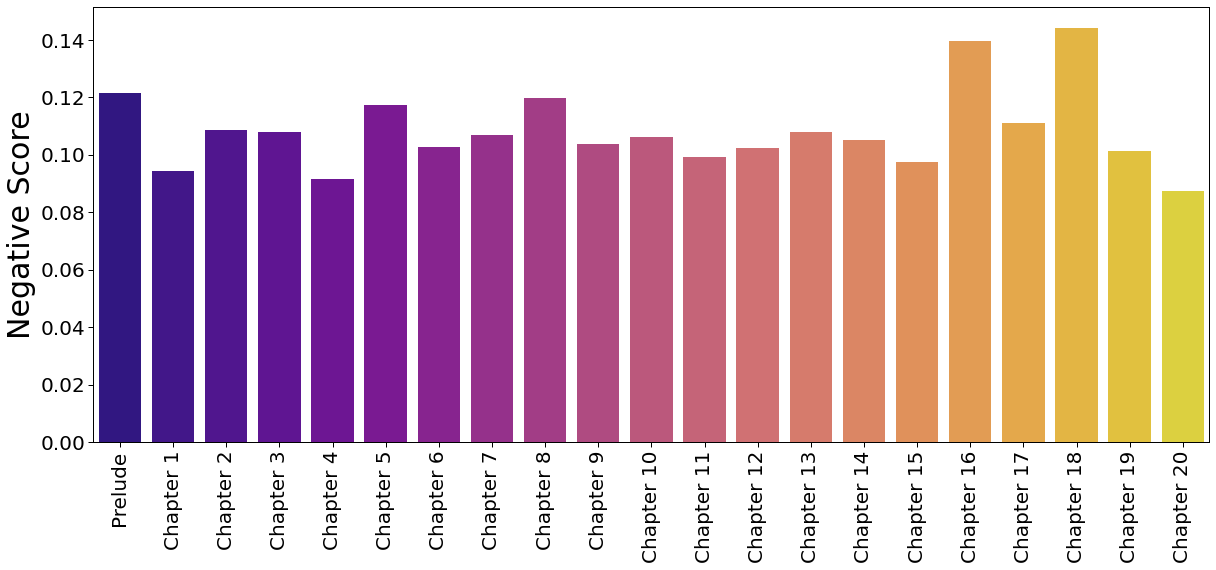

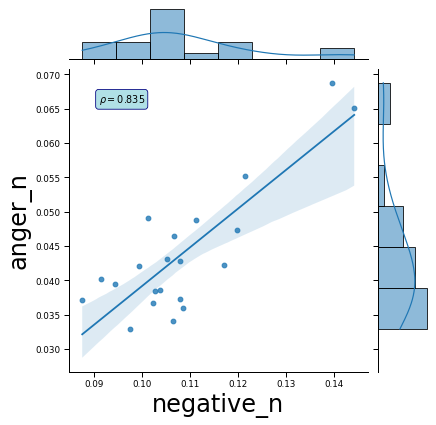

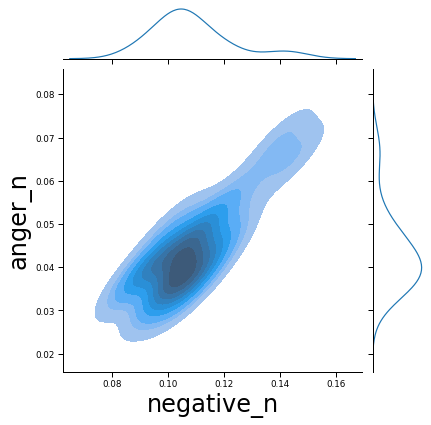

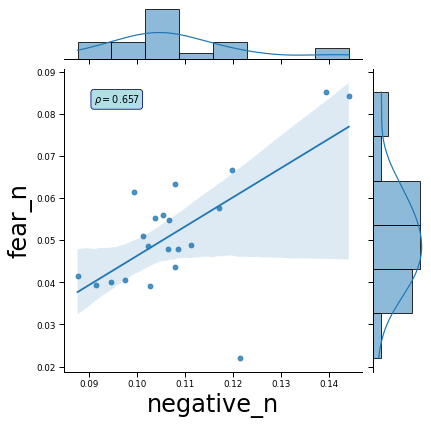

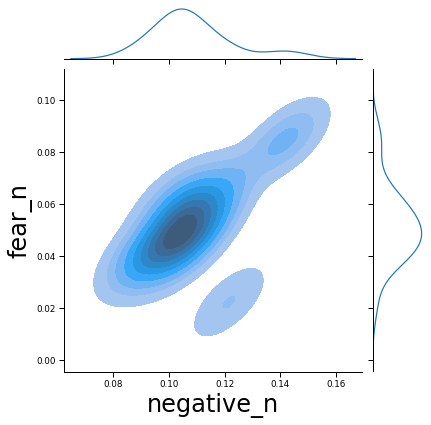

In [204]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['negative_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Negative Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['negative_n'], df_pos['anger_n'])
a0 = sns.jointplot(x="negative_n", y="anger_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="negative_n", y="anger_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['negative_n'], df_pos['fear_n'])
a2 = sns.jointplot(x="negative_n", y="fear_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="negative_n", y="fear_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Anger
Anger is defined as 'a strong feeling of displeasure or annoyance and often of active opposition to an insult, injury, or injustice'. Anger behaves in the same way as Negative sentiments. It starts relatively low and remains steady until it peaks in Chapters 16 and 18 before decaying again.

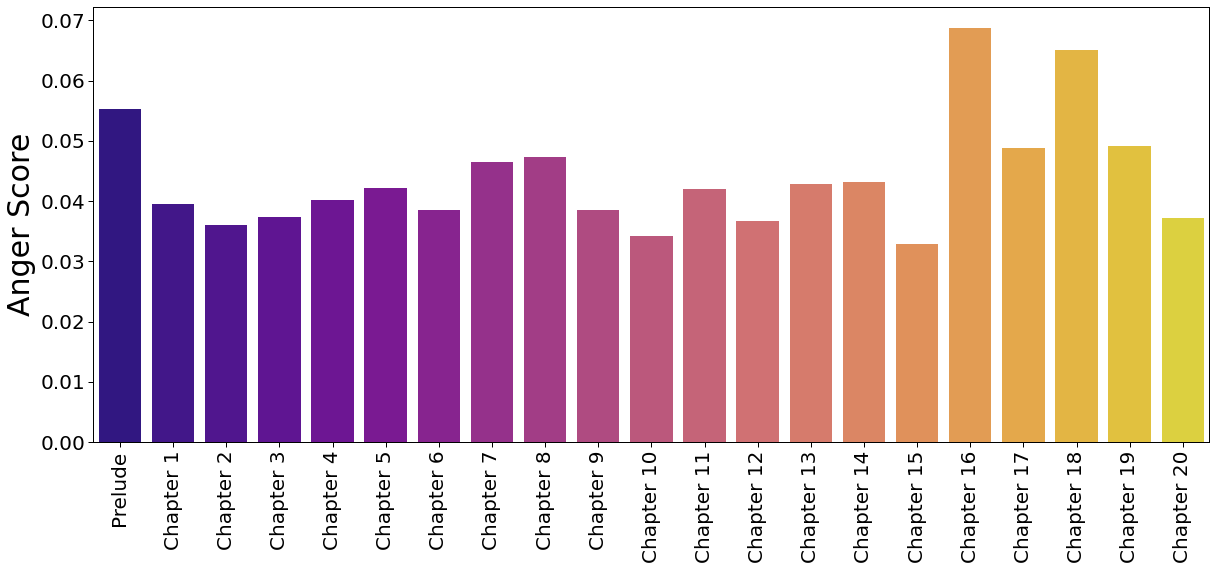

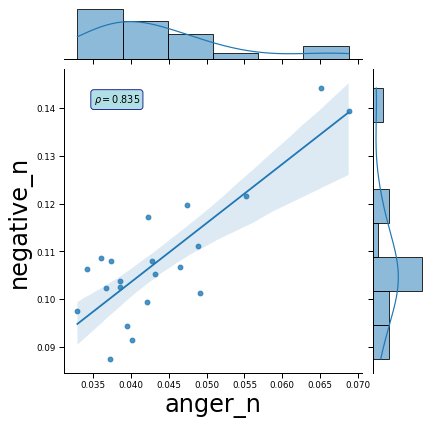

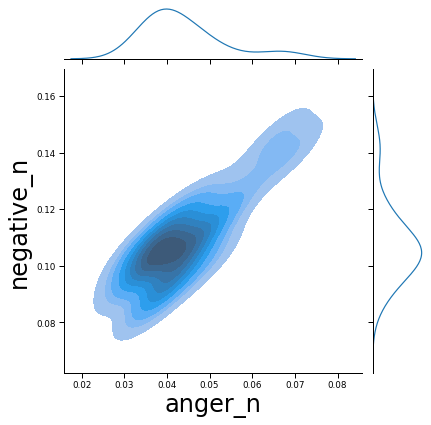

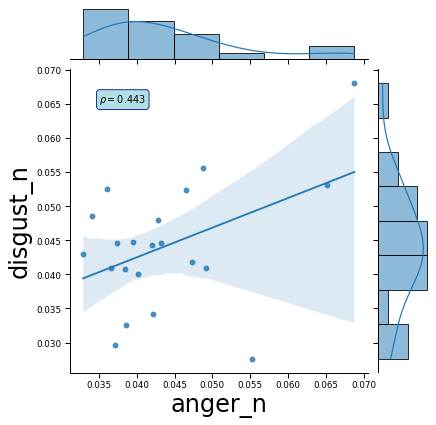

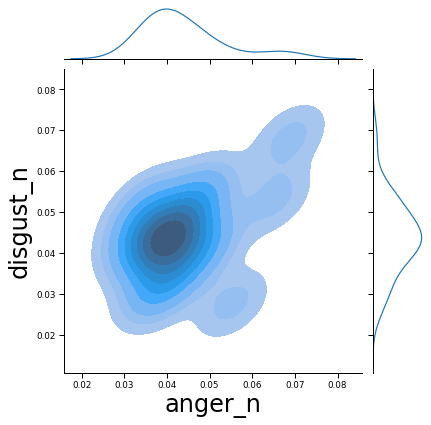

In [206]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['anger_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Anger Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['anger_n'], df_pos['negative_n'])
a0 = sns.jointplot(x="anger_n", y="negative_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="anger_n", y="negative_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['anger_n'], df_pos['disgust_n'])
a2 = sns.jointplot(x="anger_n", y="disgust_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="anger_n", y="disgust_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Disgust
Disgust is defined as 'a feeling of revulsion or strong disapproval aroused by something unpleasant or offensive'. Disgust seems to be gradually trending upwards until it peaks in CHapter 16. Then, it starts to decay until the end of the book.

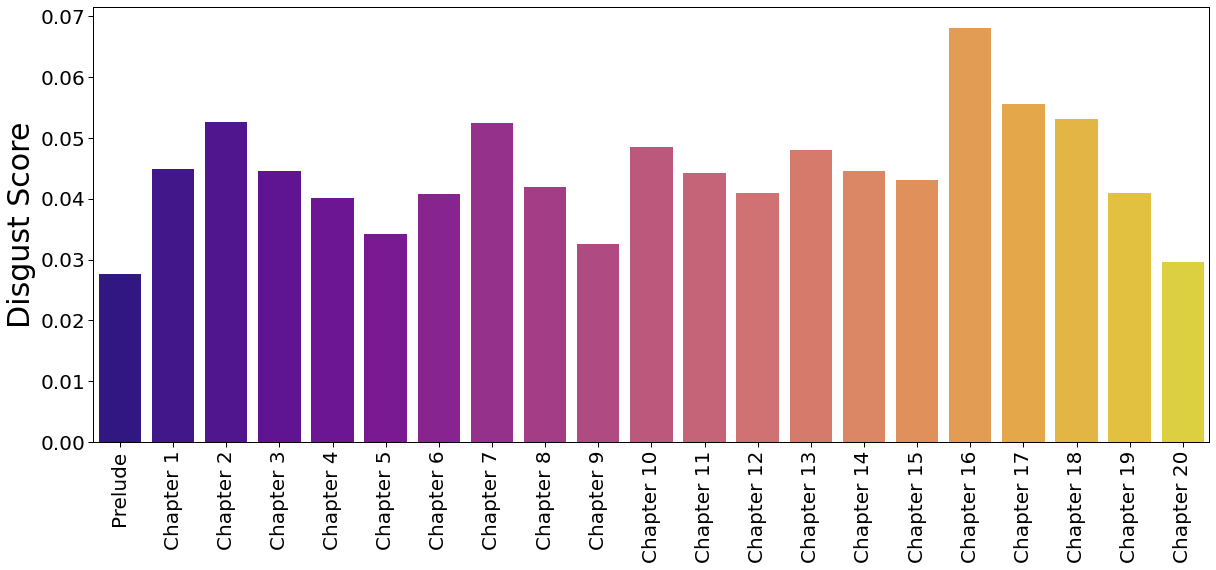

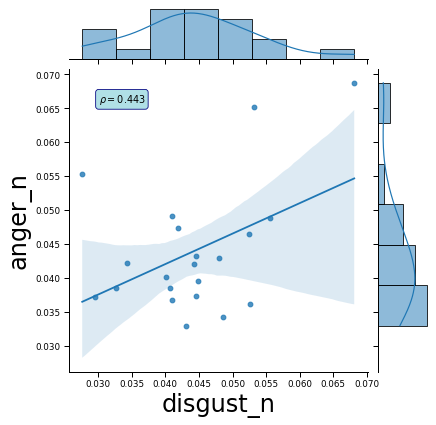

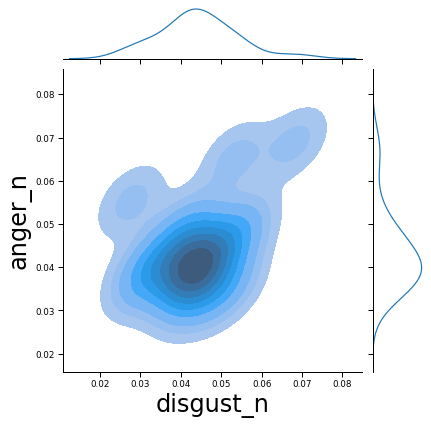

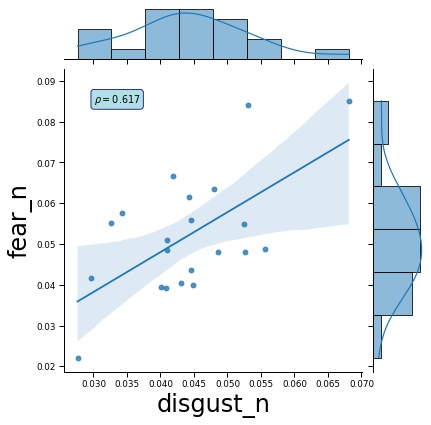

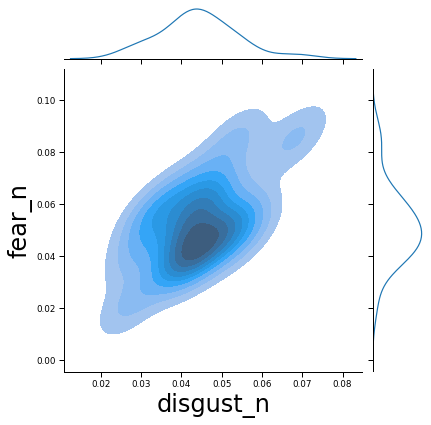

In [207]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['disgust_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Disgust Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['disgust_n'], df_pos['anger_n'])
a0 = sns.jointplot(x="disgust_n", y="anger_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="disgust_n", y="anger_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['disgust_n'], df_pos['fear_n'])
a2 = sns.jointplot(x="disgust_n", y="fear_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="disgust_n", y="fear_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Trust
Trust is defined as the 'firm belief in the reliability, truth, ability, or strength of someone or something'. Trust trends upwards until Chapter 7. After Chapter 7, it drops and remains low for the rest of the book.

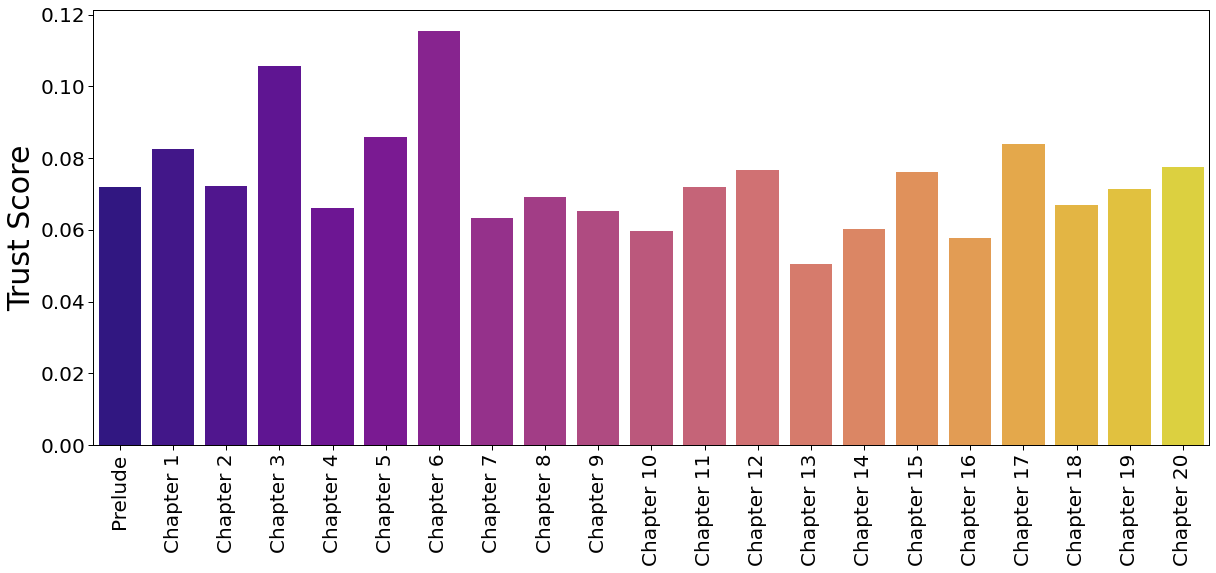

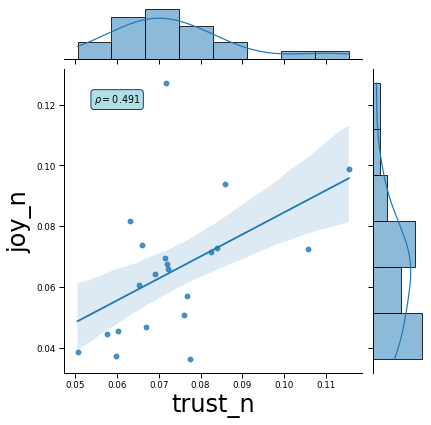

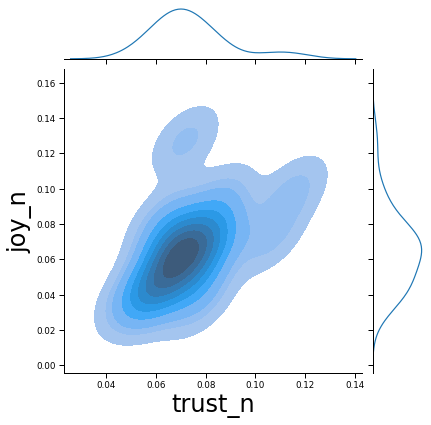

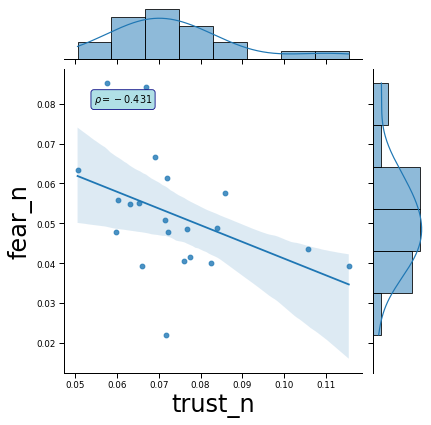

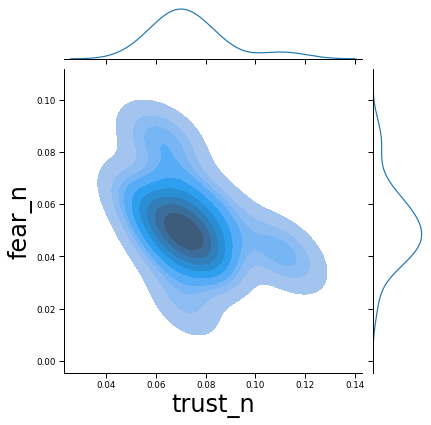

In [208]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['trust_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Trust Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['trust_n'], df_pos['joy_n'])
a0 = sns.jointplot(x="trust_n", y="joy_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="trust_n", y="joy_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['trust_n'], df_pos['fear_n'])
a2 = sns.jointplot(x="trust_n", y="fear_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="trust_n", y="fear_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

### Fear
Fear is defined as 'an unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat'. Fear creeps upwards throughout most of the book. Peaking in Chapters 16 and 18 after which it starts to decay until the end.

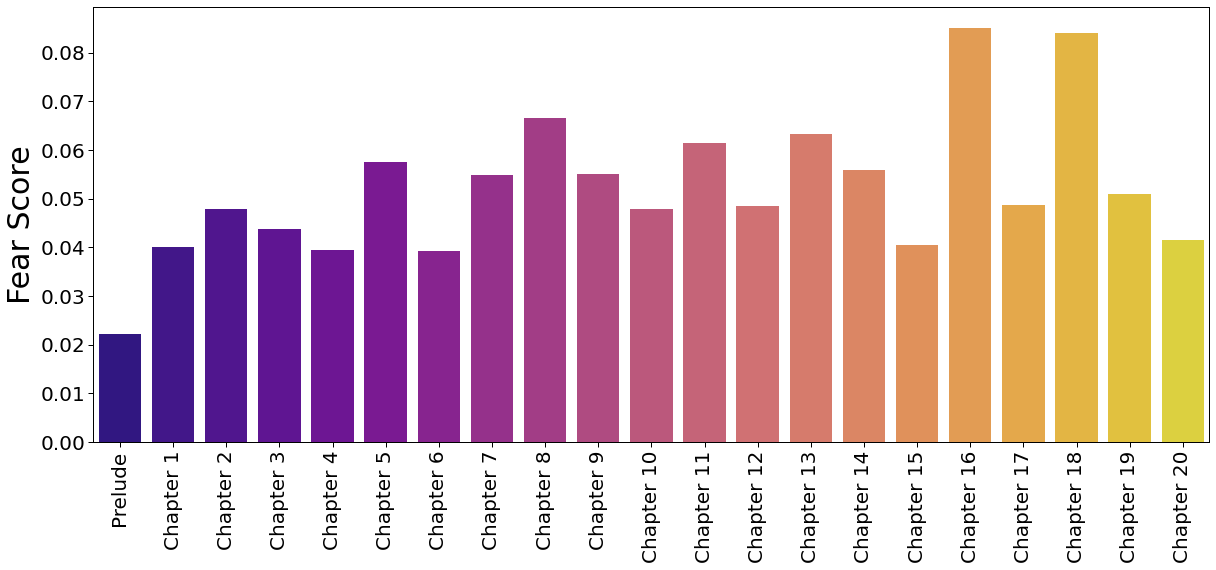

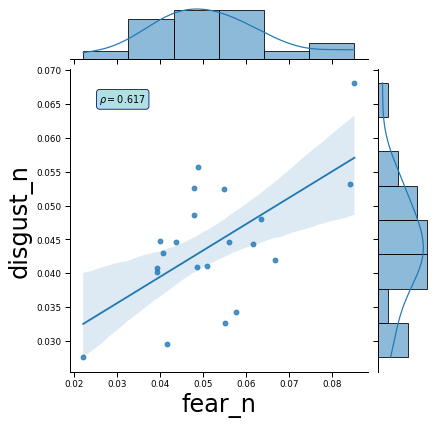

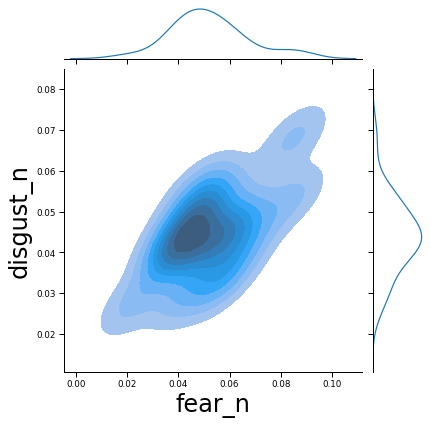

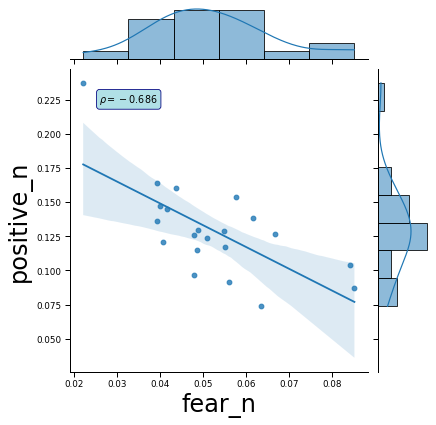

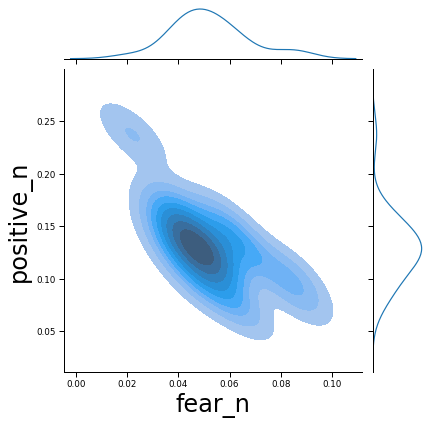

In [210]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize = (20,8))
sns.barplot(data = df_pos,
             x = df_pos['Chapter_Name'],
             y = df_pos['fear_n'],
             palette = 'plasma')
plt.xticks(rotation=90 , fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Fear Score',fontsize = 30)
plt.xlabel('')
plt.show()

from scipy import stats
#Regression plot 1
r, p = stats.pearsonr(df_pos['fear_n'], df_pos['disgust_n'])
a0 = sns.jointplot(x="fear_n", y="disgust_n", data=df_pos, kind='reg', fit_reg=True, ci = 90)
a0.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 1
sns.jointplot(x="fear_n", y="disgust_n", data=df_pos, kind='kde',shade=True)

#Regression plot 3
r, p = stats.pearsonr(df_pos['fear_n'], df_pos['positive_n'])
a2 = sns.jointplot(x="fear_n", y="positive_n"    , data=df_pos, kind='reg')
a2.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

#KDE plot 3
sns.jointplot(x="fear_n", y="positive_n"    , data=df_pos, kind='kde',shade=True)
plt.show()

Let me plot them together now.

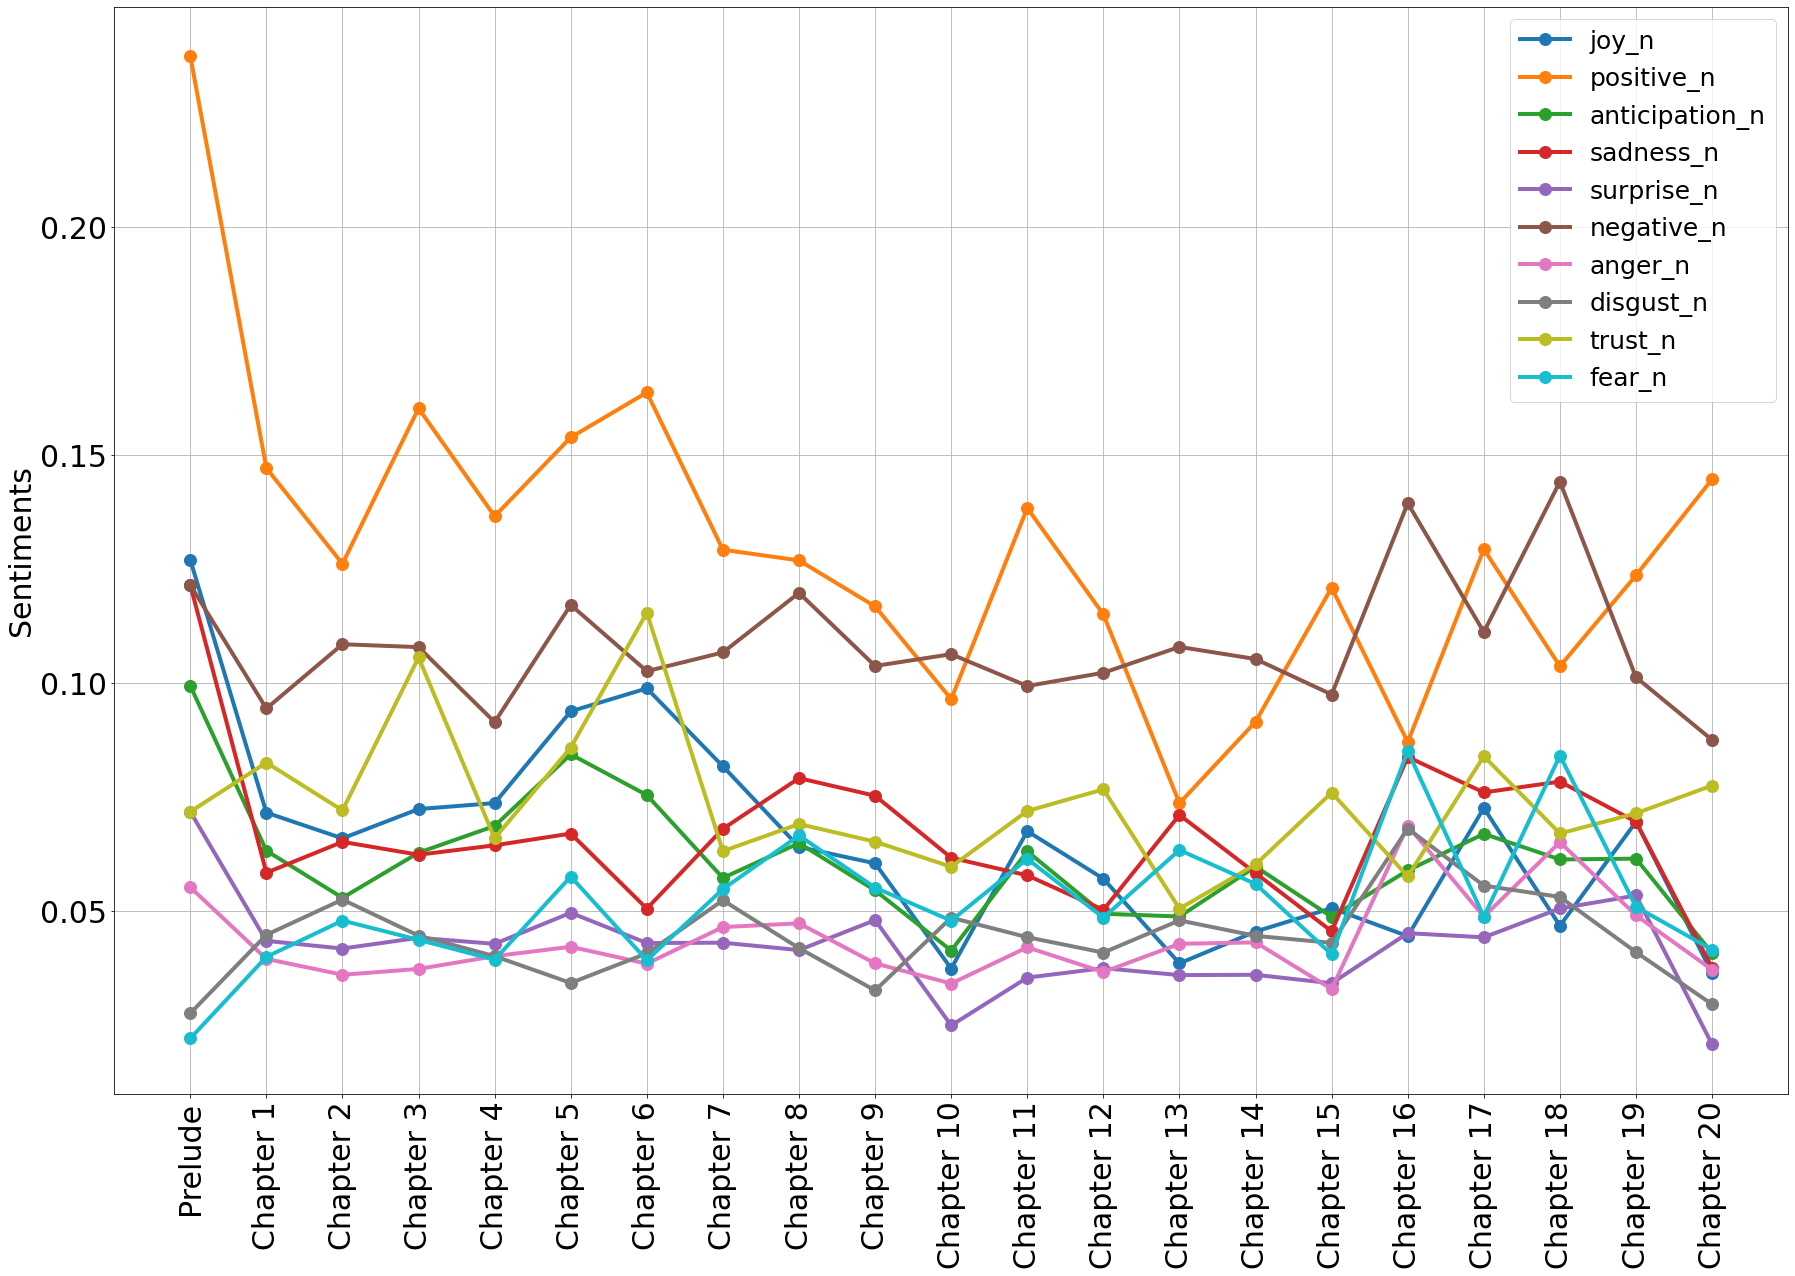

In [607]:
col_names = ['joy_n', 'positive_n', 'anticipation_n', 'sadness_n',
             'surprise_n', 'negative_n', 'anger_n', 'disgust_n', 'trust_n','fear_n']

fig = plt.figure(figsize=(30, 20))
colors = plt.cm.rainbow(np.linspace(0, 1, 30))
plt.plot(df_pos["Chapter_Name"], 
         df_pos[col_names],
         marker='o',  
         markersize=12, 
         linewidth=4,
         label = col_names)
plt.xticks(fontsize = 30,rotation = 90)
plt.yticks(fontsize = 30)
plt.ylabel('Sentiments',fontsize = 30)
plt.legend(fontsize = 25)
plt.grid(True)
plt.show()

Interesting. The positive sentiment remains dominant throughout most of the book. It is overtaken by the negative sentiment in Chapters 10, 13, 14, 16 and 18 though. Sadness is on par with the positive sentiment on Chapter 13 as well. The book appears to end on a positive note.

## Word Cloud for The Portrait of Dorian Gray
Here's a neat visualization for the top words in The Portrait of Dorian Gray. The bigger the word size the more frequently it appears and viceversa. It appears some of the most common words in the book are life, know, one, go and look.

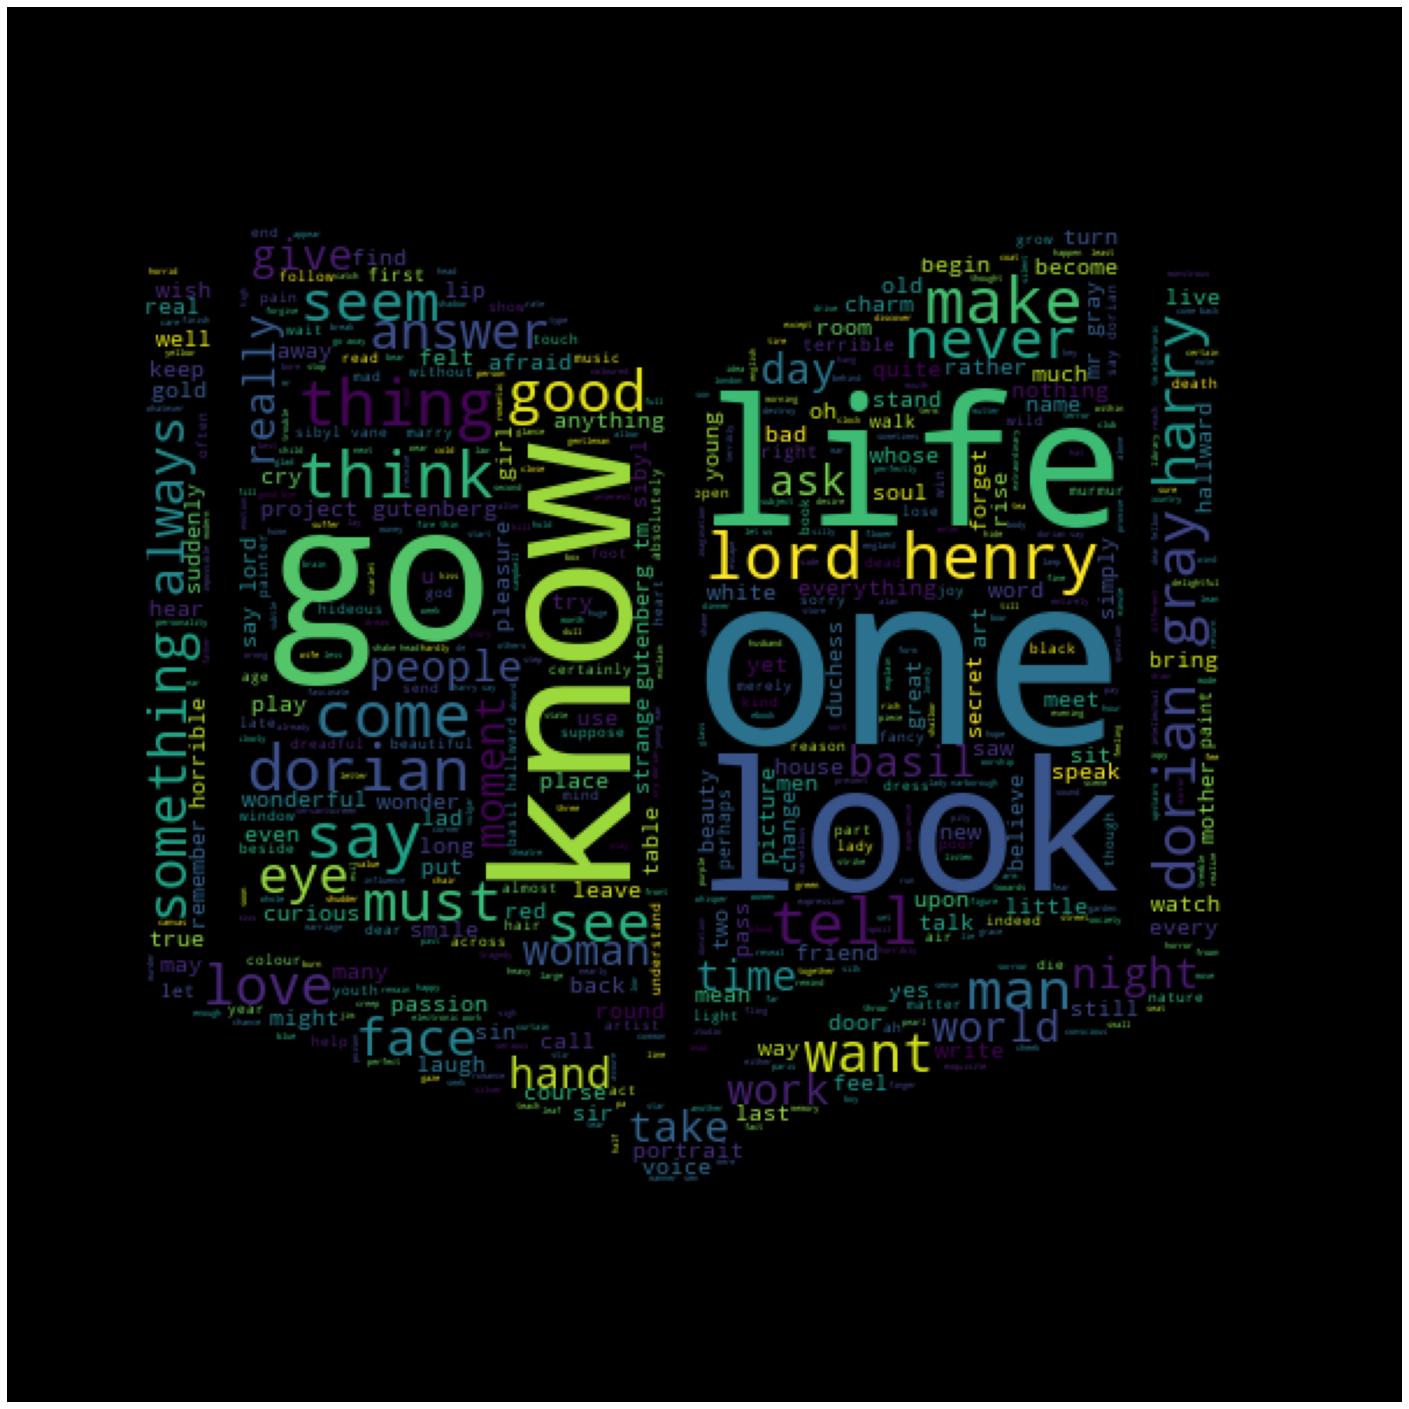

In [543]:
mask = np.array(Image.open("book.jpg"))

# generate the word cloud for the positive tweets   
WC = WordCloud(
                          max_words=5000,
                          mask = mask,
                          contour_width=2,
                          max_font_size=150,
                          font_step=2,
                          background_color='black',
                          width=298,
                          height=169
                          ).generate(str(chap_list))

fig = plt.figure(figsize=(25,30))
plt.axis("off")
plt.imshow(WC)
plt.show()

## Conclusions
Sentiment Analysis and Emotion Recognition was used to analyze 'The Portrait of Dorian Gray' by Oscar Wilde. The results of the routine showcased here elucidated some of the thematic/emotional structure of that book using a Naive Bayes classifier, VADER and NRC lexicons for every chapter in the book. The next steps for this project involve processing the remaining works from Oscar Wilde and seeing if there is a common emotional structure in his books.